In [52]:
#!pip install imgkit --quiet # For rendering images from HTML tables

In [53]:
#!sudo apt-get install wkhtmltopdf

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
#from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib.lines import Line2D  
#import imgkit
from PIL import Image

---
## **Loading data with tree structures and Pareto fronts**

In [55]:
DATA_DATAPATH = './zips/'+ 'interactive-data.zip'

In [56]:
%%capture
!unzip -o $DATA_DATAPATH -d datasets

In [57]:
#!rm -r 'files' 

## **Tree Parsing and Visualization**

In [58]:
# This is for DOT files containing prefix trees
def parse_trie(filename):
  trie = nx.drawing.nx_pydot.read_dot(filename)
  trie.remove_node("\\n") # This is an error in the parsing
  for n, data in trie.nodes(data=True):
    data['fillcolor'] = data['fillcolor'].strip("\"")
    data['label'] = data['label'].strip("\"")
    data['width'] = float(data['width'].strip("\""))
    data['ninstances'] = int(data['ninstances'].strip("\""))
  
  for n, m, data in trie.edges(data=True):
    data['width'] = float(data['width'].strip("\""))

  print(trie.number_of_nodes(), "nodes")
  print(trie.number_of_edges(), "edges")
  return trie

In [59]:
def find_node(trie, path, nlabel='source'):
  root = trie.nodes['0']
  #print("tree root:", root)
  n = '0'
  for v in path:
    matching = False
    for s in trie.successors(n):
      #print(tries.nodes[s])
      if trie.nodes[s][nlabel] == v:
        matching = True
        #print(v, "...got a match=", s)
        n = s
        break

    if not matching:
      #print("matching aborted for", v)
      n = None
      break
  
  return n

def get_sequence_as_path(trie, sequence, root='0'):
  node = find_node(trie, sequence)
  path = nx.shortest_path(trie, source=root, target=node)
  return path

def draw_prefix_tree(trie, size=(15,15), layout='graphviz', prog='twopi', title=None, 
                     nlabel='source', paths=None, ninstances=True, margin=0.0, color='red'):

  final_nodes = []
  if ninstances:
    for n in trie.nodes():
      if trie.out_degree(n) == 0:
        final_nodes.append(n)

  # Get properties for the nodes from their attributes
  labels = nx.get_node_attributes(trie, nlabel) #nx.get_node_attributes(trie, 'refaction')
  line_colors = nx.get_node_attributes(trie, 'color').values()
  node_colors =  nx.get_node_attributes(trie, 'fillcolor') # ['#FFFFFF']*trie.number_of_nodes()
  linewidths =  list(nx.get_node_attributes(trie, 'width').values())
  sizes_dict = nx.get_node_attributes(trie, 'ninstances')
  sizes = [300+30*(s-1) if (k in final_nodes) else 300 for (k,s) in sizes_dict.items()]

  edge_linewidths = 1.0
  edge_colors = 'black'
  edge_list = None
  if paths is not None:
    flat_list = set([item for sublist in paths for item in sublist])
    for n in flat_list:
      node_colors[n] = color
    edge_linewidths = list()
    edge_colors = list()
    edge_list = list()
    for n, m in trie.edges():
      edge_list.append((n,m))
      if (n in flat_list) and (m in flat_list):
        edge_linewidths.append(2.0)
        edge_colors.append(color)
      else:
        edge_linewidths.append(1.0)
        edge_colors.append('black')

  fig = plt.figure(figsize=size) 
  fig.suptitle(title, fontsize=30)

  if layout == 'graphviz':
    pos = graphviz_layout(trie, prog=prog, root='0')
    nodes = nx.draw_networkx_nodes(trie, pos, node_color=node_colors.values(), linewidths=linewidths, node_size=sizes, )
    nodes.set_edgecolors(line_colors)
    labels = nx.draw_networkx_labels(trie, pos, labels=labels)
    edges = nx.draw_networkx_edges(trie, pos, edgelist=edge_list, width=edge_linewidths, edge_color=edge_colors)
  else:
    nodes = nx.draw_networkx_nodes(trie, pos=nx.spring_layout(trie), node_color='cyan', node_size=sizes)
    labels = nx.draw_networkx_labels(trie, pos=nx.spring_layout(trie))
    edges = nx.draw_networkx_edges(trie, pos=nx.spring_layout(trie))

 #'a': 'Move_Component_New_Node',
 #'b': 'Move_Operation_Component',
 #'c': 'Move_Operation_New_Component_New_Node',
 #'d': 'UMLCloneNode'}
  if paths is not None:
    legend_elements = [
      Line2D([0],[0], marker='o', markeredgecolor='black', markersize=15, color='w', label='a: ReDe'), 
      Line2D([0],[0], marker='o', markeredgecolor='black', markersize=15, color='w', label='b: MO2C'), 
      Line2D([0],[0], marker='o', markeredgecolor='black', markersize=15, color='w', label='c: MO2N'), 
      Line2D([0],[0], marker='o', markeredgecolor='black', markersize=15, color='w', label='d: Clon') 
    ]
    plt.legend(handles=legend_elements, loc='upper right', prop={'size': 18}, bbox_to_anchor=(1.0, 1.05))
  
  plt.margins(margin)
  fig.tight_layout() 
  plt.grid(visible=False)
  plt.box(False)
  
  plt.show()

157 nodes
156 edges


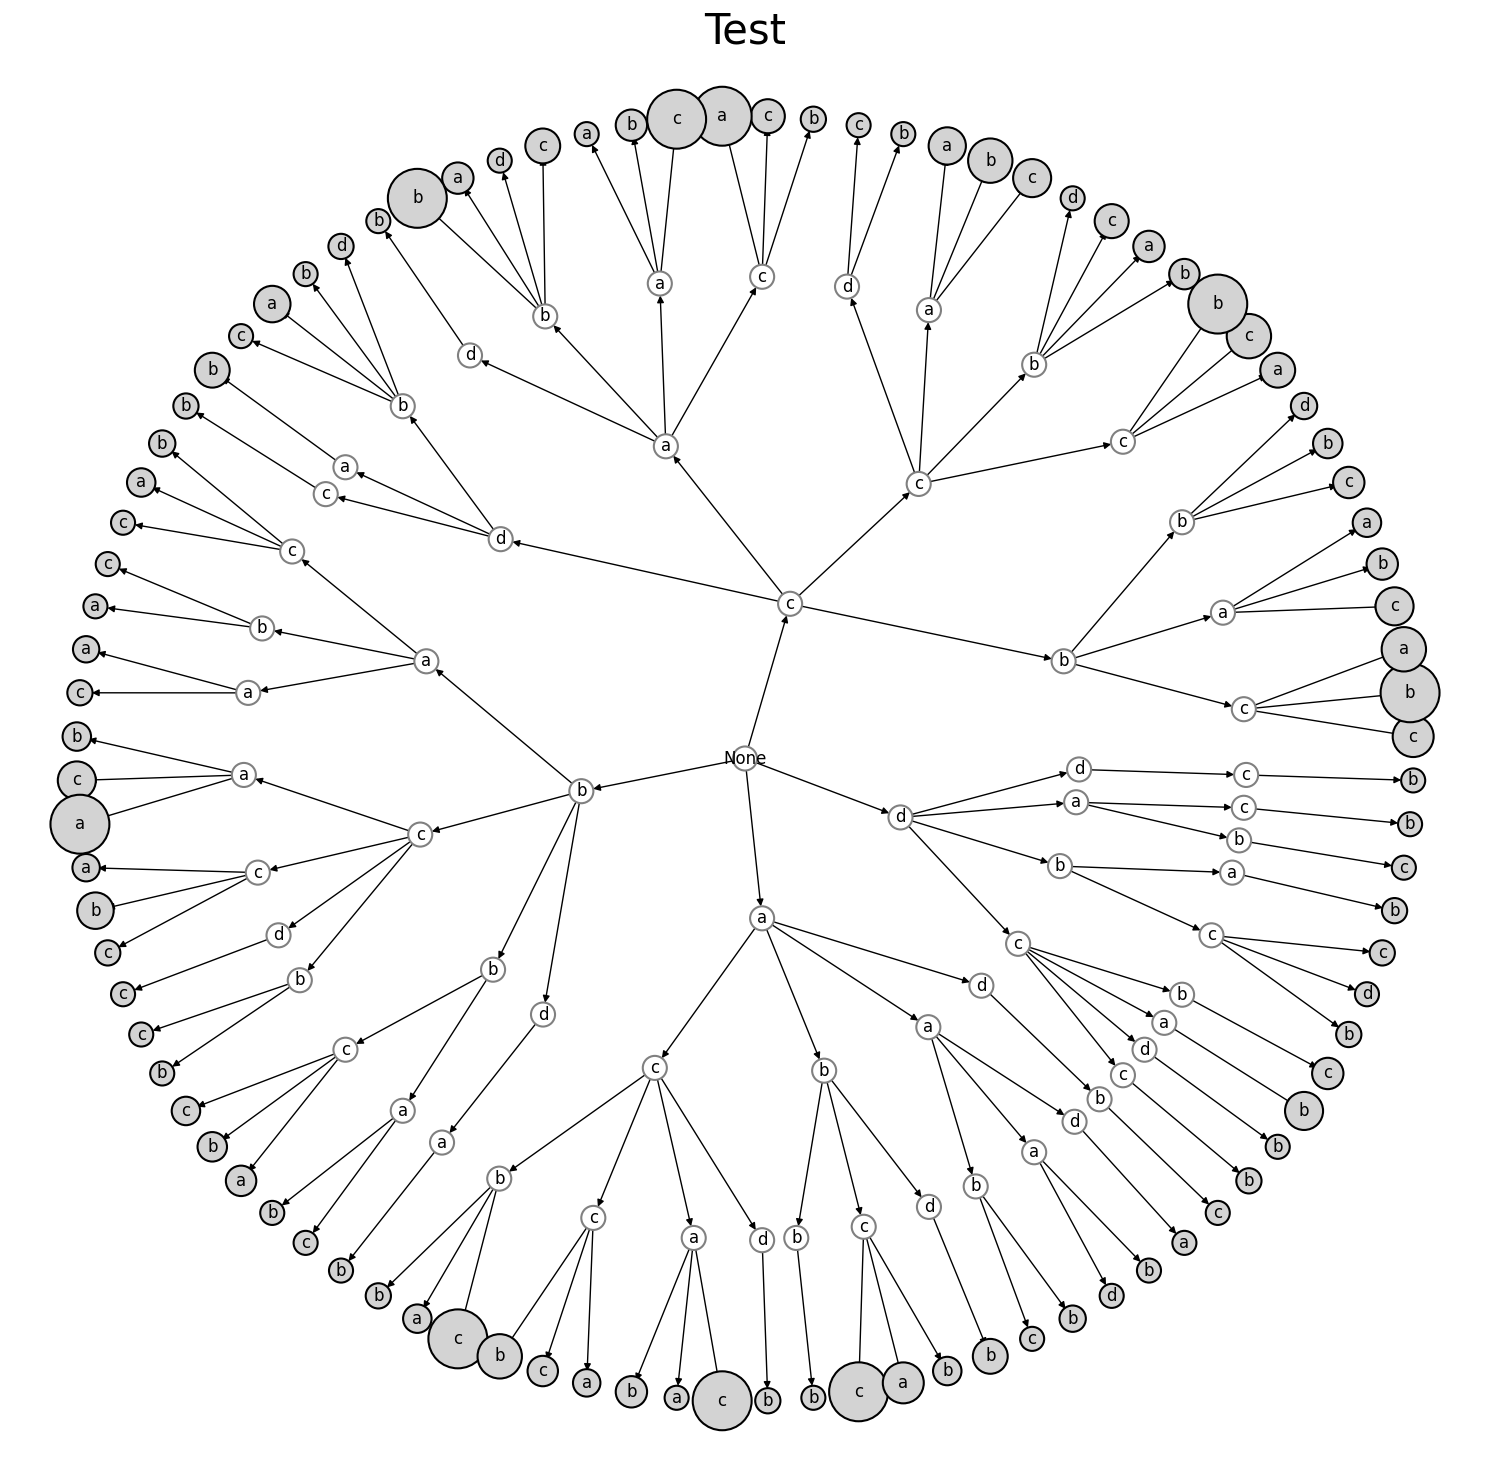

In [60]:
# Loading a particular tree in DOT format
it0_100_trie = parse_trie('./datasets/cocome-nsgaii-it0_100_baseline_trie.dot')
draw_prefix_tree(it0_100_trie, title='Test', nlabel='source')

In [61]:
# Functions for comparing tree paths
def sequence_match(s1, s2, trie1, trie2):
  seq1 = ''.join([trie1.nodes[n]['source'] for n in s1])[len('None'):]
  seq2 = ''.join([trie2.nodes[n]['source'] for n in s2])[len('None'):]
  #print(seq1, "=?=", seq2)
  return (seq1 == seq2), seq1, seq2

def compare_tries(trie1, trie2, size=(10,10), title1='', title2='', margin=0.05, color='orange', ninstances=True):

  final_nodes1 = [n for n in trie1.nodes() if trie1.out_degree(n) == 0]
  final_nodes2 = [n for n in trie2.nodes() if trie2.out_degree(n) == 0]

  sequences1 = [tuple(nx.shortest_path(trie1,'0', n)) for n in final_nodes1]
  print(len(sequences1), "sequences")
  #print(sequences1)
  encoding = dict()
  for x in sequences1:
    encoding[trie1.nodes[x[0]]['source']] = trie1.nodes[x[0]]['refaction']
    encoding[trie1.nodes[x[1]]['source']] = trie1.nodes[x[1]]['refaction']
    encoding[trie1.nodes[x[2]]['source']] = trie1.nodes[x[2]]['refaction']
    encoding[trie1.nodes[x[3]]['source']] = trie1.nodes[x[3]]['refaction']
  #print(encoding)

  sequences2 = [tuple(nx.shortest_path(trie2,'0', n)) for n in final_nodes2]
  print(len(sequences2), "sequences")
  #print(sequences2)
  #encoding = dict()
  for x in sequences2:
    encoding[trie2.nodes[x[0]]['source']] = trie2.nodes[x[0]]['refaction']
    encoding[trie2.nodes[x[1]]['source']] = trie2.nodes[x[1]]['refaction']
    encoding[trie2.nodes[x[2]]['source']] = trie2.nodes[x[2]]['refaction']
    encoding[trie2.nodes[x[3]]['source']] = trie2.nodes[x[3]]['refaction']
  print("Encoding:", encoding)

  intersection1 = []
  intersection2 = []
  seq_matching = []
  for s1 in sequences1:
    for s2 in sequences2:
      matching, seq1, seq2 = sequence_match(s1, s2, trie1, trie2)
      if matching:
        #print("matching:", seq1, seq2)
        seq_matching.append(seq1)
        intersection1.append(s1)
        intersection2.append(s2)

  t = nx.prefix_tree(seq_matching)
  print(t.number_of_nodes())
  print("intersection:", len(seq_matching), seq_matching)
  
  coverage1 = (t.number_of_nodes()-2)/(trie1.number_of_nodes()-1)
  coverage2 = (t.number_of_nodes()-2)/(trie2.number_of_nodes()-1)
  print("Coverage of "+title2+" on reference "+title1+": ", coverage1)
  print("Coverage of "+title1+" on reference "+title2+": ", coverage2)

  title1 = f'coverage = {100*coverage1:.2f}%'
  title2 = f'coverage = {100*coverage2:.2f}%'
  draw_prefix_tree(trie1, paths=intersection1, nlabel='source', ninstances=ninstances, size=size, title=title1, margin=margin, color=color)
  draw_prefix_tree(trie2, paths=intersection2, nlabel='source', ninstances=ninstances, size=size, title=title2, margin=margin, color=color)

  return encoding

In [62]:
#import matplotlib
#matplotlib.rcParams.update({'font.size': 8})

## **Tree comparison - COCOME**

157 nodes
156 edges
19 nodes
18 edges
92 sequences
12 sequences
Encoding: {'None': 'None', 'c': 'Move_Operation_New_Component_New_Node', 'b': 'Move_Operation_Component', 'a': 'Move_Component_New_Node', 'd': 'UMLCloneNode'}
11
intersection: 5 ['bbcc', 'bbcb', 'bbca', 'bbab', 'bbac']
Coverage of CoCoMe / NSGAII / c317 on reference CoCoMe / NSGAII / 100-baseline:  0.057692307692307696
Coverage of CoCoMe / NSGAII / 100-baseline on reference CoCoMe / NSGAII / c317:  0.5


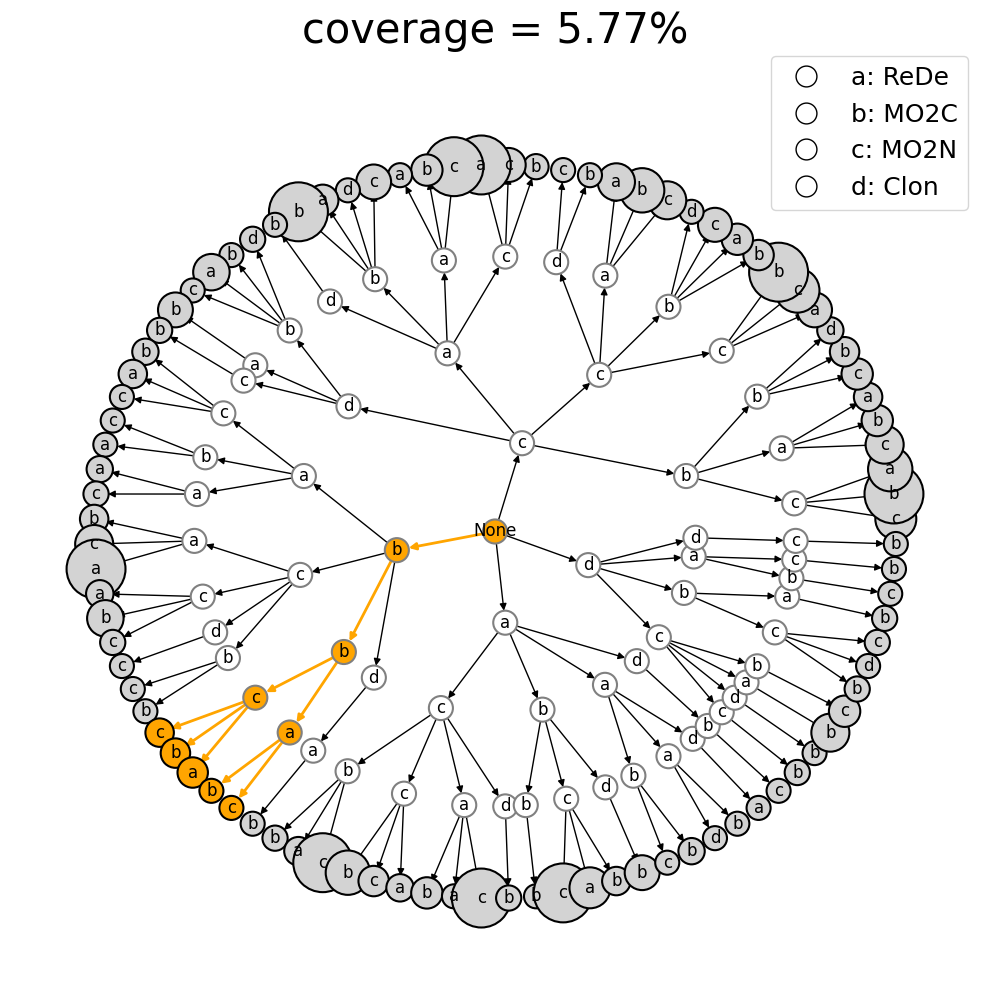

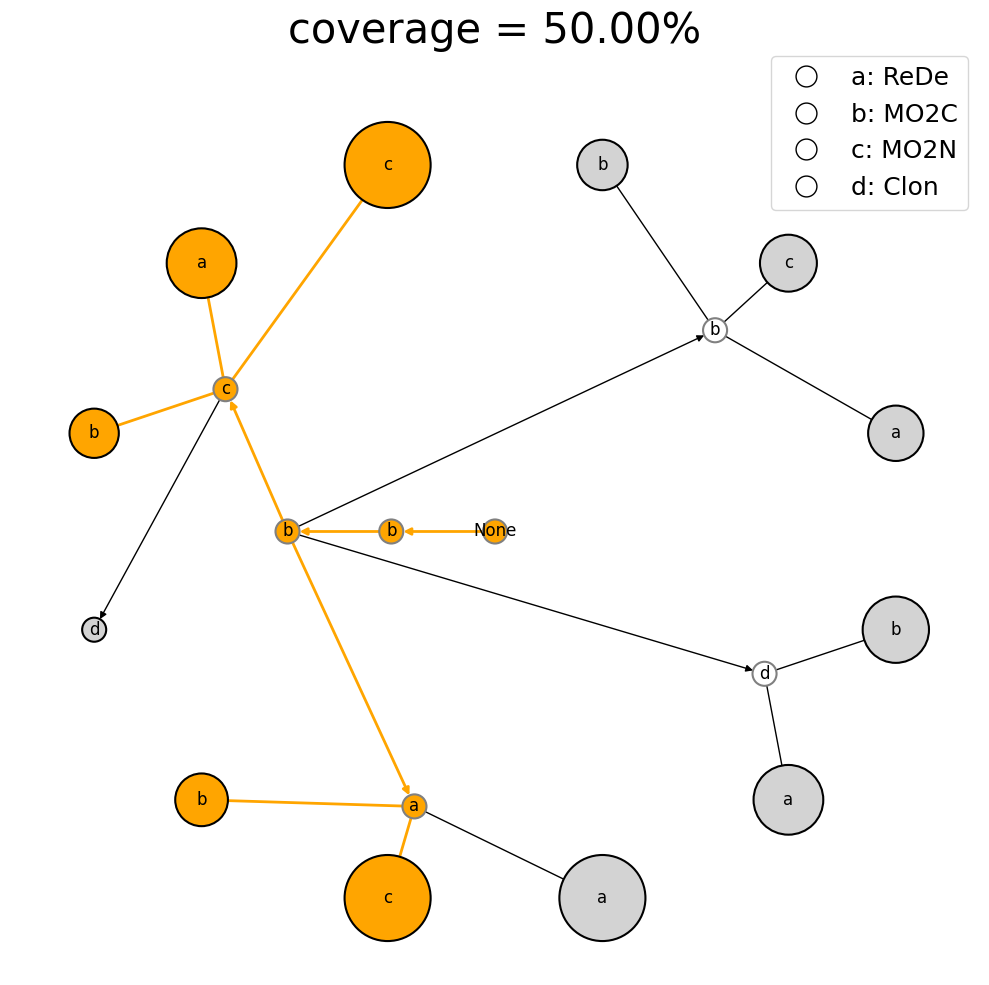

{'None': 'None',
 'c': 'Move_Operation_New_Component_New_Node',
 'b': 'Move_Operation_Component',
 'a': 'Move_Component_New_Node',
 'd': 'UMLCloneNode'}

In [63]:
# Code that loads 2 trees (in DOT format) and then compares them - COCOME
ref100_trie = parse_trie('./datasets/cocome-nsgaii-it0_100_baseline_trie.dot')
it1_c317 = parse_trie('./datasets/cocome-nsgaii-it1_50_c317_trie.dot')

compare_tries(ref100_trie, it1_c317, title1='CoCoMe / NSGAII / 100-baseline', title2='CoCoMe / NSGAII / c317')

155 nodes
154 edges
96 sequences
92 sequences
Encoding: {'None': 'None', 'a': 'Move_Component_New_Node', 'c': 'Move_Operation_New_Component_New_Node', 'b': 'Move_Operation_Component', 'd': 'UMLCloneNode'}
108
intersection: 63 ['aaab', 'aabb', 'aabc', 'accb', 'accc', 'acca', 'acac', 'acab', 'acaa', 'acbc', 'acbb', 'acba', 'abcb', 'abcc', 'abca', 'bccb', 'bccc', 'bcca', 'bcbb', 'bcbc', 'bcab', 'bcac', 'bcaa', 'bcdc', 'bbcc', 'bbcb', 'bbac', 'bbab', 'bacc', 'baca', 'bacb', 'baac', 'babc', 'cacb', 'caca', 'cacc', 'caac', 'caab', 'caaa', 'cabb', 'cabc', 'caba', 'cccb', 'cccc', 'ccca', 'ccbc', 'ccbb', 'ccba', 'ccac', 'ccab', 'ccaa', 'cbcb', 'cbcc', 'cbca', 'cbac', 'cbaa', 'cbab', 'cbbb', 'cbbc', 'cdbb', 'cdbc', 'dcab', 'dbcc']
Coverage of CoCoMe / NSGAII / 100-baseline on reference CoCoMe / NSGAII / 1000-baseline:  0.6883116883116883
Coverage of CoCoMe / NSGAII / 1000-baseline on reference CoCoMe / NSGAII / 100-baseline:  0.6794871794871795


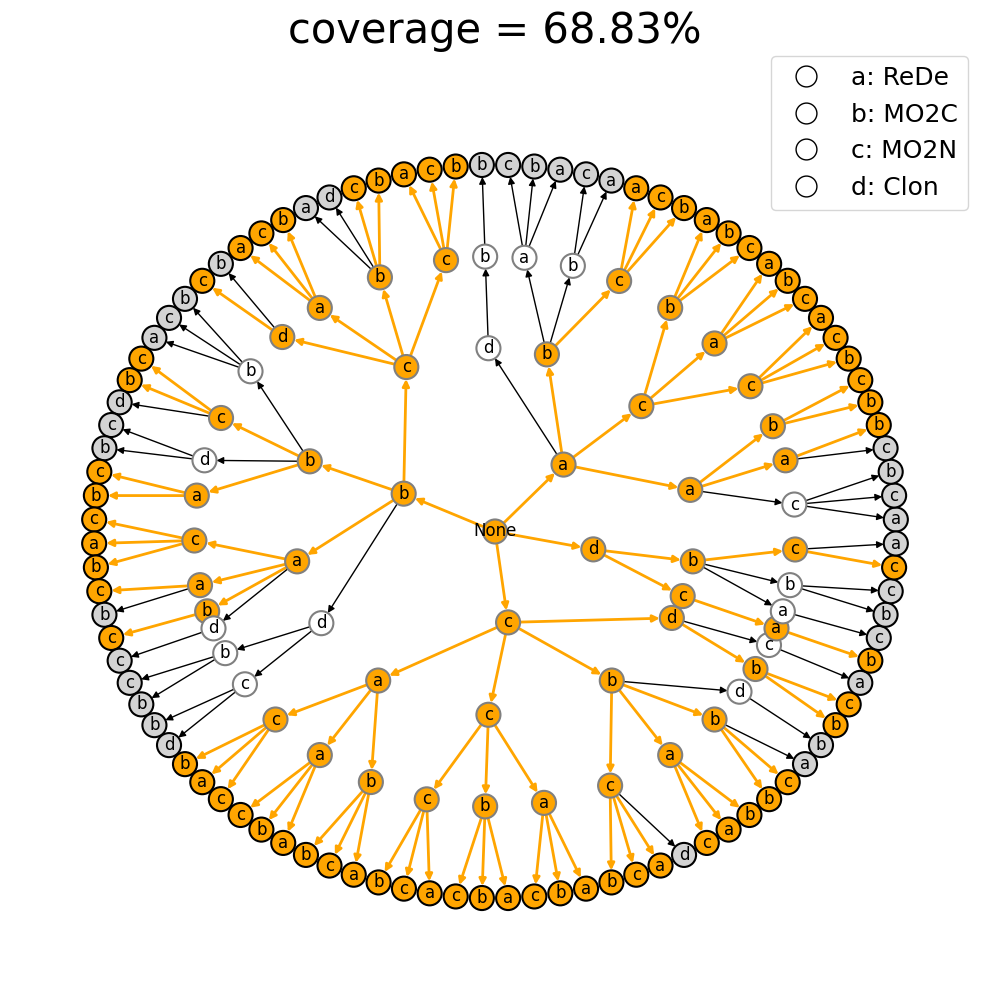

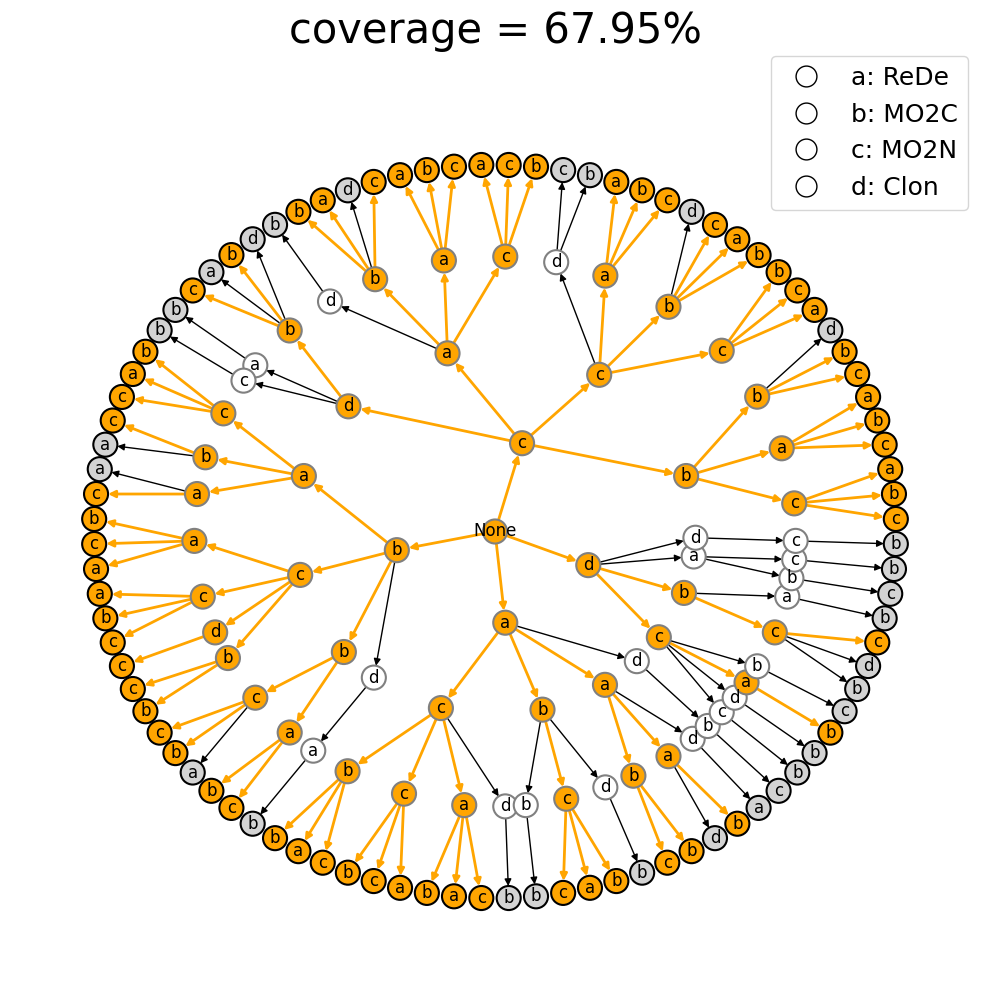

{'None': 'None',
 'a': 'Move_Component_New_Node',
 'c': 'Move_Operation_New_Component_New_Node',
 'b': 'Move_Operation_Component',
 'd': 'UMLCloneNode'}

In [64]:
ref1000_trie = parse_trie('./datasets/cocome-nsgaii-it0_1000_baseline_trie.dot')

compare_tries(ref1000_trie, ref100_trie, title1='CoCoMe / NSGAII / 1000-baseline', title2='CoCoMe / NSGAII / 100-baseline', ninstances=False)

157 nodes
156 edges
20 nodes
19 edges
92 sequences
13 sequences
Encoding: {'None': 'None', 'c': 'Move_Operation_New_Component_New_Node', 'b': 'Move_Operation_Component', 'a': 'Move_Component_New_Node', 'd': 'UMLCloneNode'}
11
intersection: 5 ['bbcc', 'bbcb', 'bbca', 'bbab', 'bbac']
Coverage of CoCoMe / NSGAII / c358 on reference CoCoMe / NSGAII / 100-baseline:  0.057692307692307696
Coverage of CoCoMe / NSGAII / 100-baseline on reference CoCoMe / NSGAII / c358:  0.47368421052631576


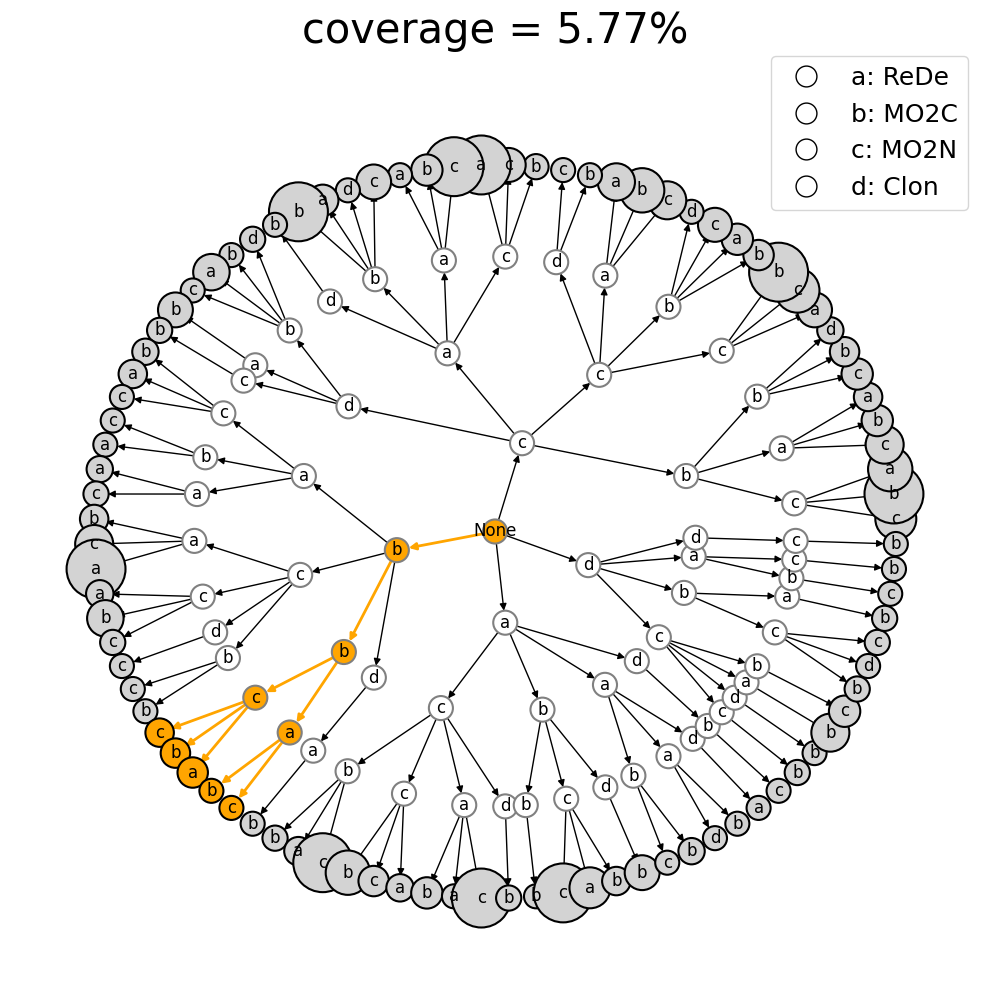

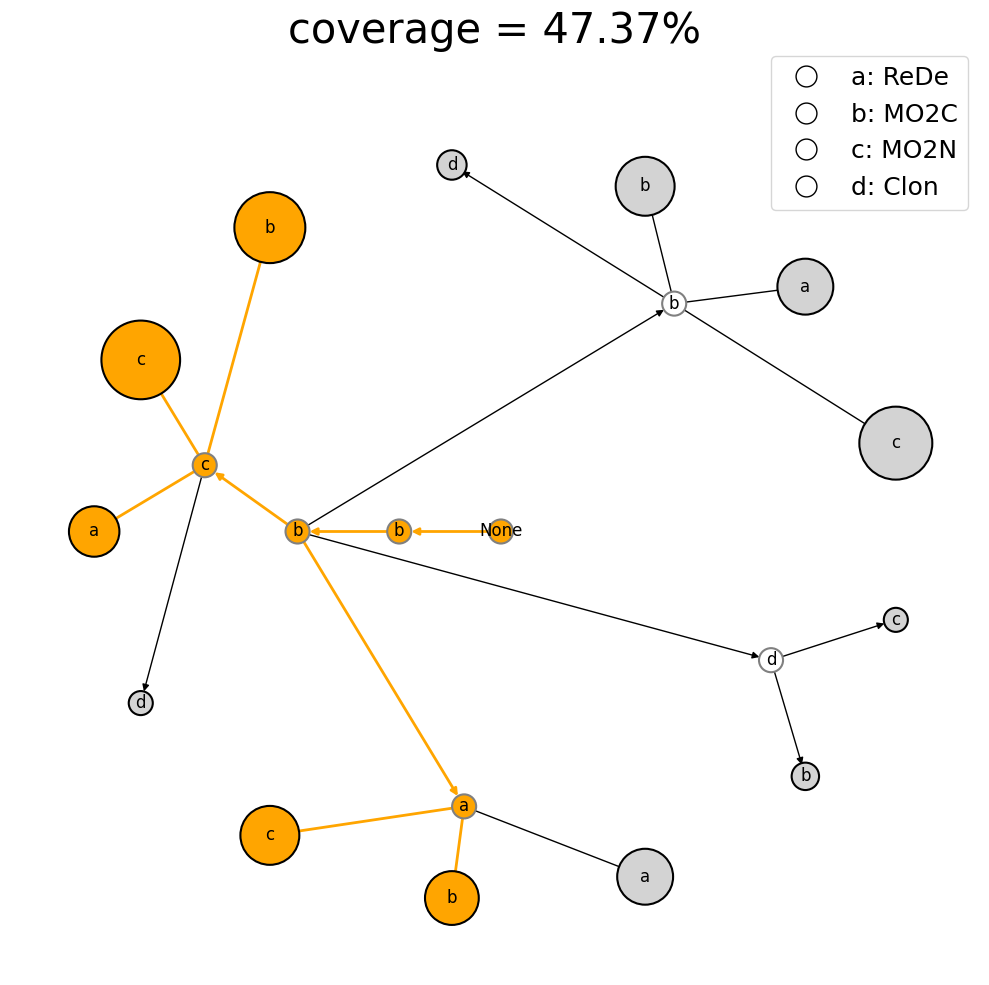

{'None': 'None',
 'c': 'Move_Operation_New_Component_New_Node',
 'b': 'Move_Operation_Component',
 'a': 'Move_Component_New_Node',
 'd': 'UMLCloneNode'}

In [65]:
# Code that loads 2 trees (in DOT format) and then compares them - COCOME
ref100_trie = parse_trie('./datasets/cocome-nsgaii-it0_100_baseline_trie.dot')
it1_c358 = parse_trie('./datasets/cocome-nsgaii-it1_50_c358_trie.dot')

compare_tries(ref100_trie, it1_c358, title1='CoCoMe / NSGAII / 100-baseline', title2='CoCoMe / NSGAII / c358')

96 sequences
12 sequences
Encoding: {'None': 'None', 'a': 'Move_Component_New_Node', 'c': 'Move_Operation_New_Component_New_Node', 'b': 'Move_Operation_Component', 'd': 'UMLCloneNode'}
17
intersection: 9 ['bbbb', 'bbbc', 'bbba', 'bbcc', 'bbcb', 'bbcd', 'bbdb', 'bbac', 'bbab']
Coverage of CoCoMe / NSGAII / c317 on reference CoCoMe / NSGAII / 1000-baseline:  0.09740259740259741
Coverage of CoCoMe / NSGAII / 1000-baseline on reference CoCoMe / NSGAII / c317:  0.8333333333333334


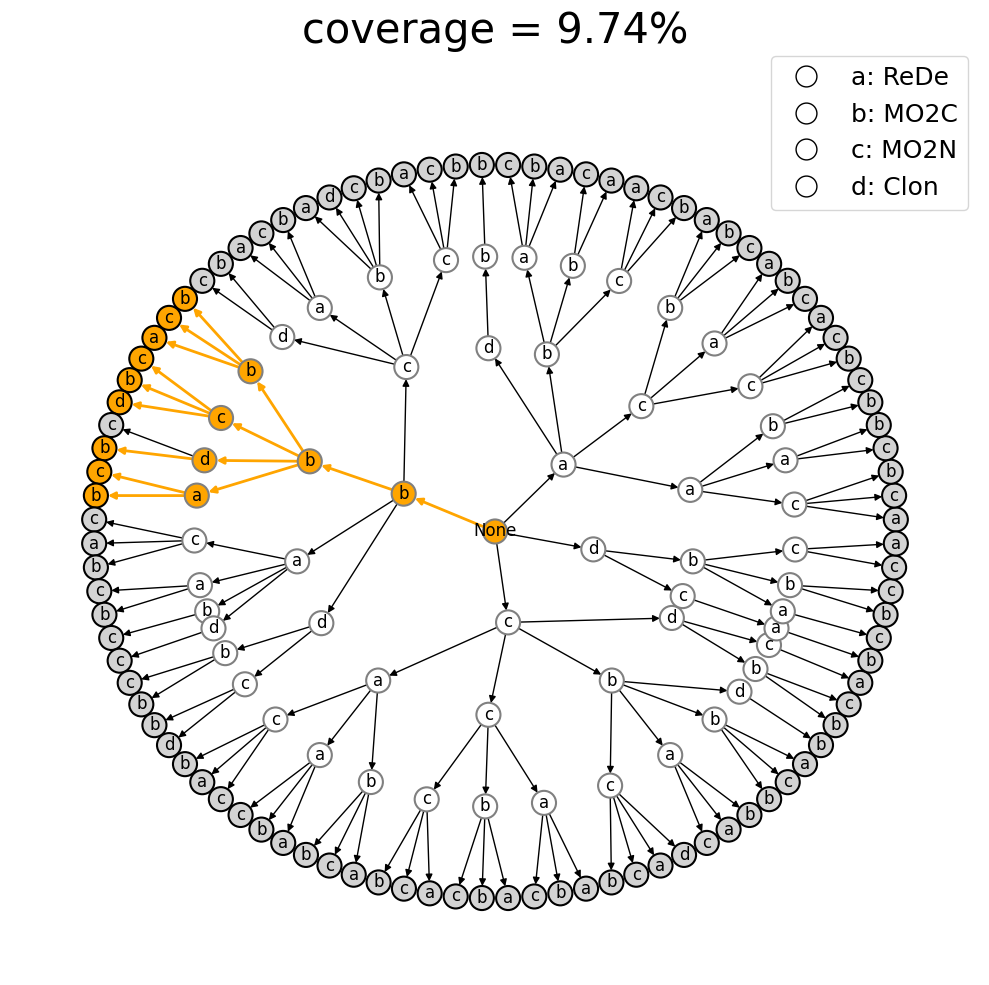

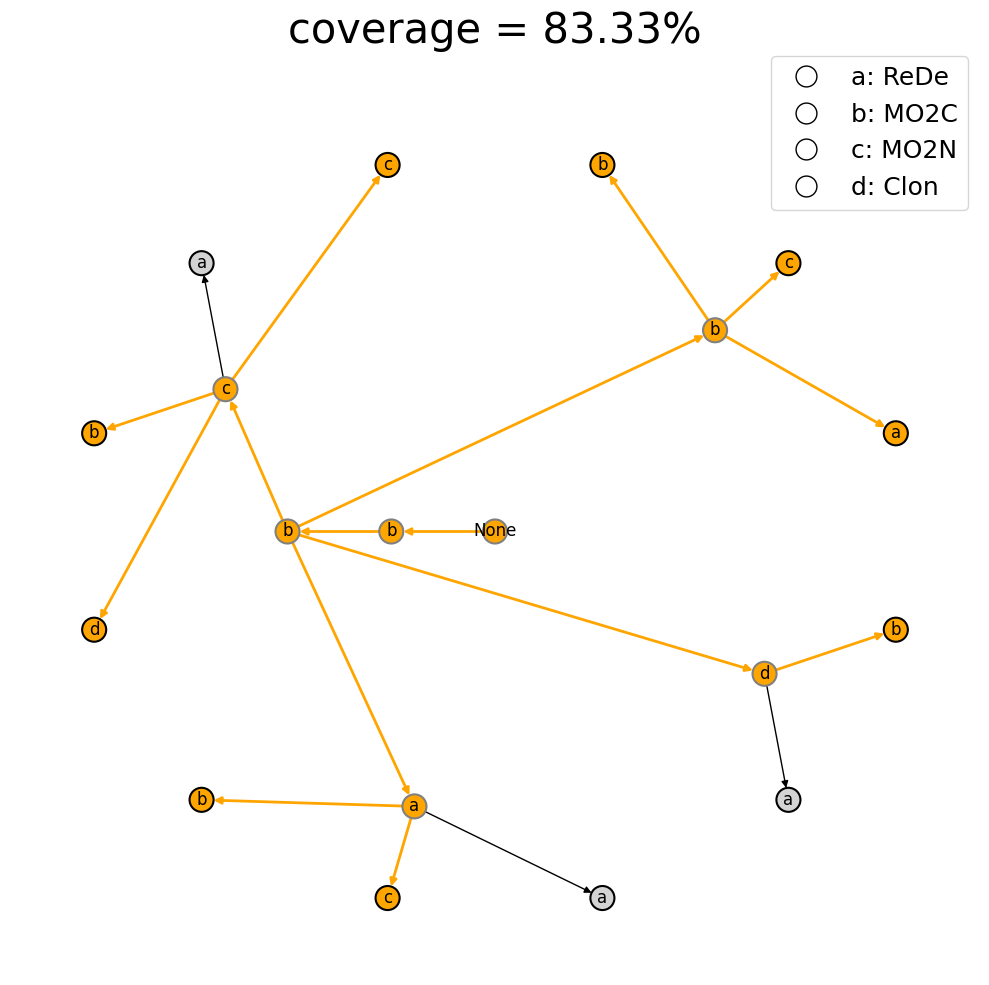

{'None': 'None',
 'a': 'Move_Component_New_Node',
 'c': 'Move_Operation_New_Component_New_Node',
 'b': 'Move_Operation_Component',
 'd': 'UMLCloneNode'}

In [66]:
compare_tries(ref1000_trie, it1_c317, title1='CoCoMe / NSGAII / 1000-baseline', title2='CoCoMe / NSGAII / c317', ninstances=False)

96 sequences
13 sequences
Encoding: {'None': 'None', 'a': 'Move_Component_New_Node', 'c': 'Move_Operation_New_Component_New_Node', 'b': 'Move_Operation_Component', 'd': 'UMLCloneNode'}
18
intersection: 10 ['bbbb', 'bbbc', 'bbba', 'bbcc', 'bbcb', 'bbcd', 'bbdc', 'bbdb', 'bbac', 'bbab']
Coverage of CoCoMe / NSGAII / c358 on reference CoCoMe / NSGAII / 1000-baseline:  0.1038961038961039
Coverage of CoCoMe / NSGAII / 1000-baseline on reference CoCoMe / NSGAII / c358:  0.8421052631578947


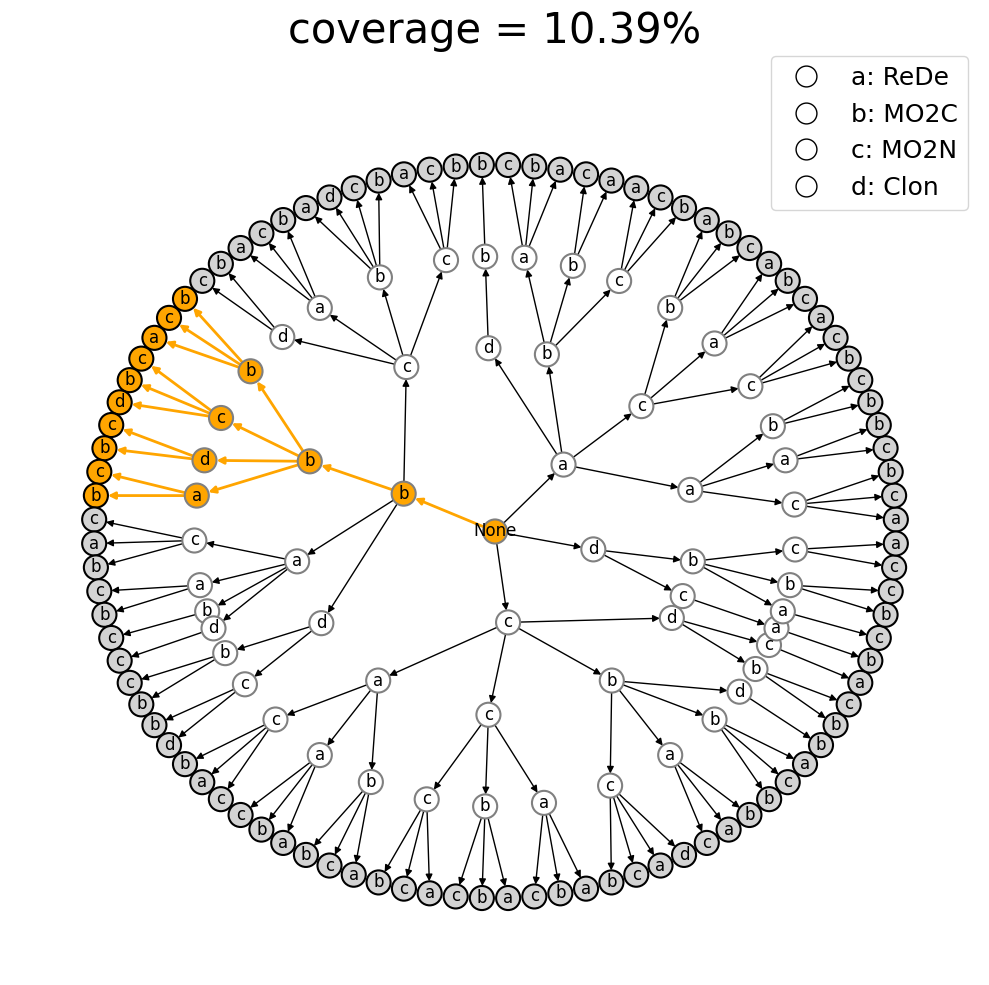

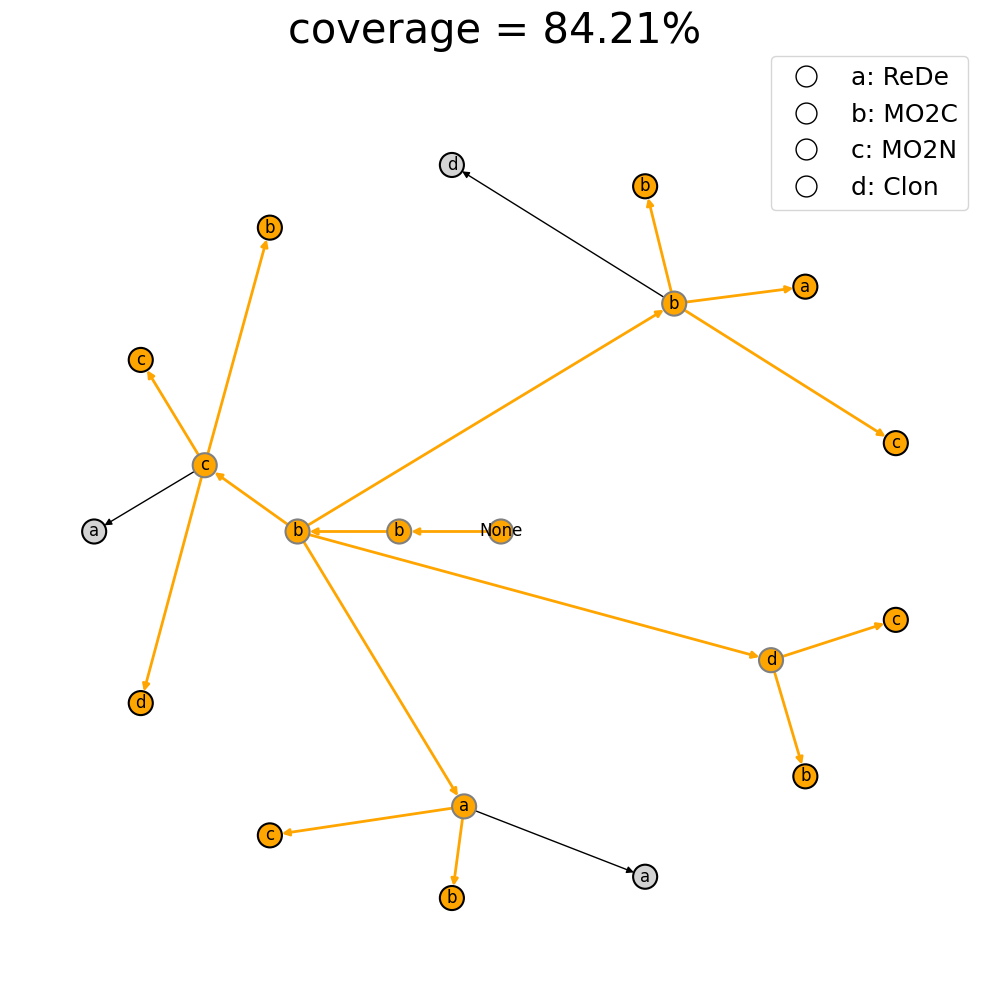

{'None': 'None',
 'a': 'Move_Component_New_Node',
 'c': 'Move_Operation_New_Component_New_Node',
 'b': 'Move_Operation_Component',
 'd': 'UMLCloneNode'}

In [67]:
compare_tries(ref1000_trie, it1_c358, title1='CoCoMe / NSGAII / 1000-baseline', title2='CoCoMe / NSGAII / c358', ninstances=False)

12 sequences
13 sequences
Encoding: {'None': 'None', 'b': 'Move_Operation_Component', 'c': 'Move_Operation_New_Component_New_Node', 'a': 'Move_Component_New_Node', 'd': 'UMLCloneNode'}
19
intersection: 11 ['bbba', 'bbbc', 'bbbb', 'bbcc', 'bbca', 'bbcb', 'bbcd', 'bbab', 'bbac', 'bbaa', 'bbdb']
Coverage of CoCoMe / NSGAII / c358 on reference CoCoMe / NSGAII / c317:  0.9444444444444444
Coverage of CoCoMe / NSGAII / c317 on reference CoCoMe / NSGAII / c358:  0.8947368421052632


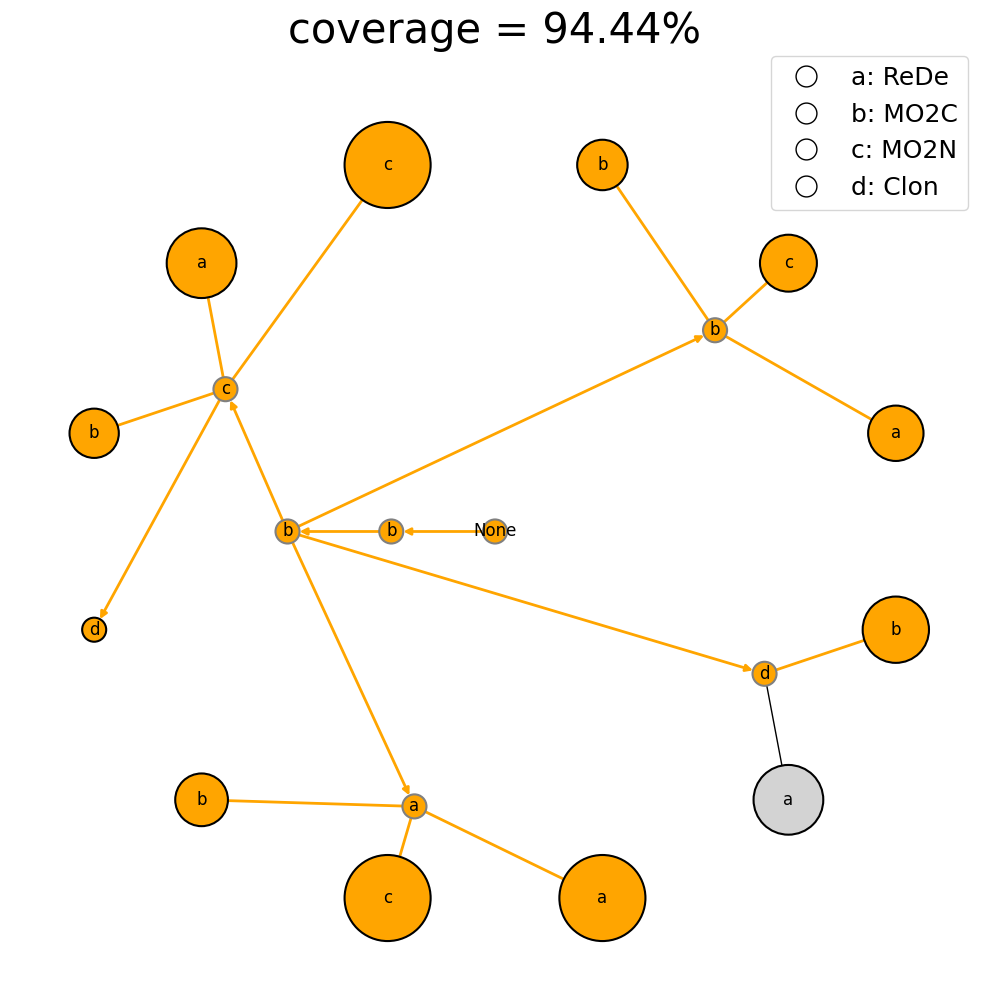

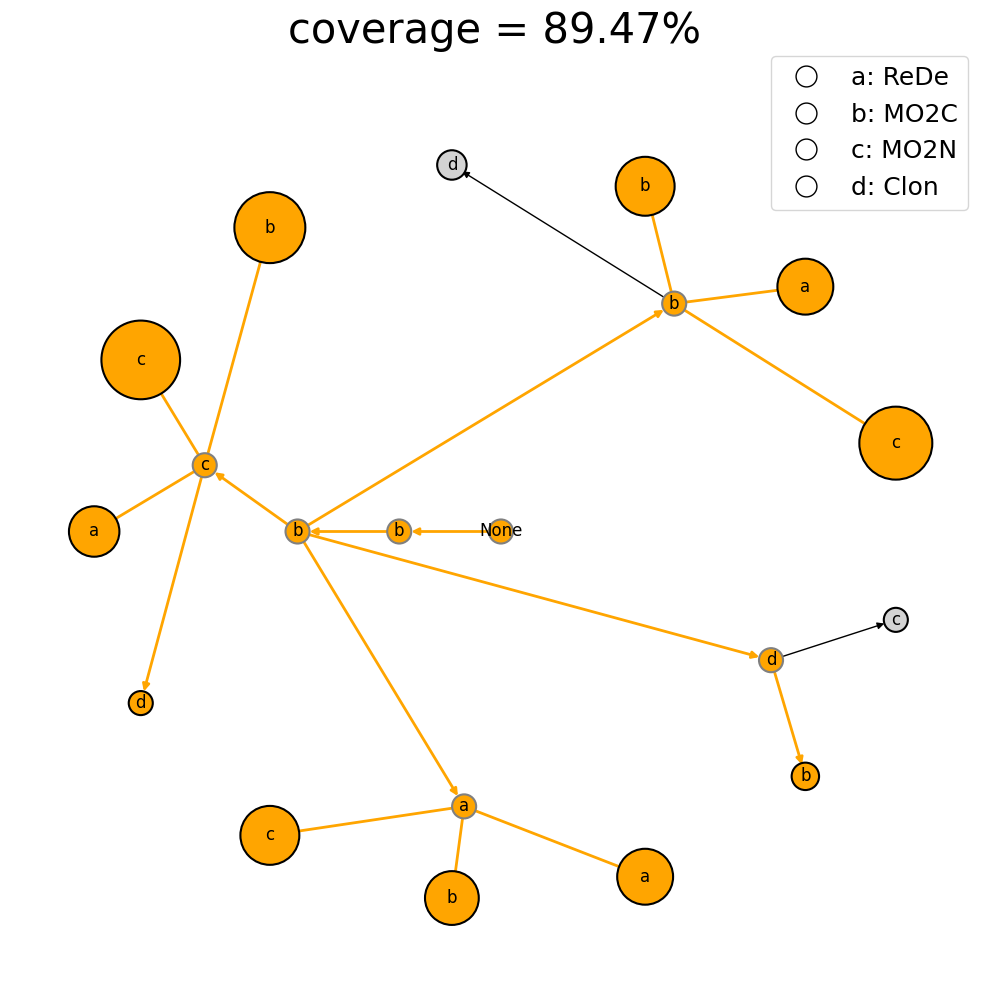

{'None': 'None',
 'b': 'Move_Operation_Component',
 'c': 'Move_Operation_New_Component_New_Node',
 'a': 'Move_Component_New_Node',
 'd': 'UMLCloneNode'}

In [68]:
compare_tries(it1_c317, it1_c358, title1='CoCoMe / NSGAII / c317', title2='CoCoMe / NSGAII / c358', size=(10,10))

## **Tree comparison - TRAINTICKET**

100 nodes
99 edges
14 nodes
13 edges
55 sequences
8 sequences
Encoding: {'None': 'None', 'c': 'Move_Operation_New_Component_New_Node', 'b': 'Move_Operation_Component', 'a': 'Move_Component_New_Node', 'd': 'UMLCloneNode'}
6
intersection: 1 ['bbbb']
Coverage of Train-ticket / NSGAII / c258 on reference Train-ticket / NSGAII / 100-baseline:  0.04040404040404041
Coverage of Train-ticket / NSGAII / 100-baseline on reference Train-ticket / NSGAII / c258:  0.3076923076923077


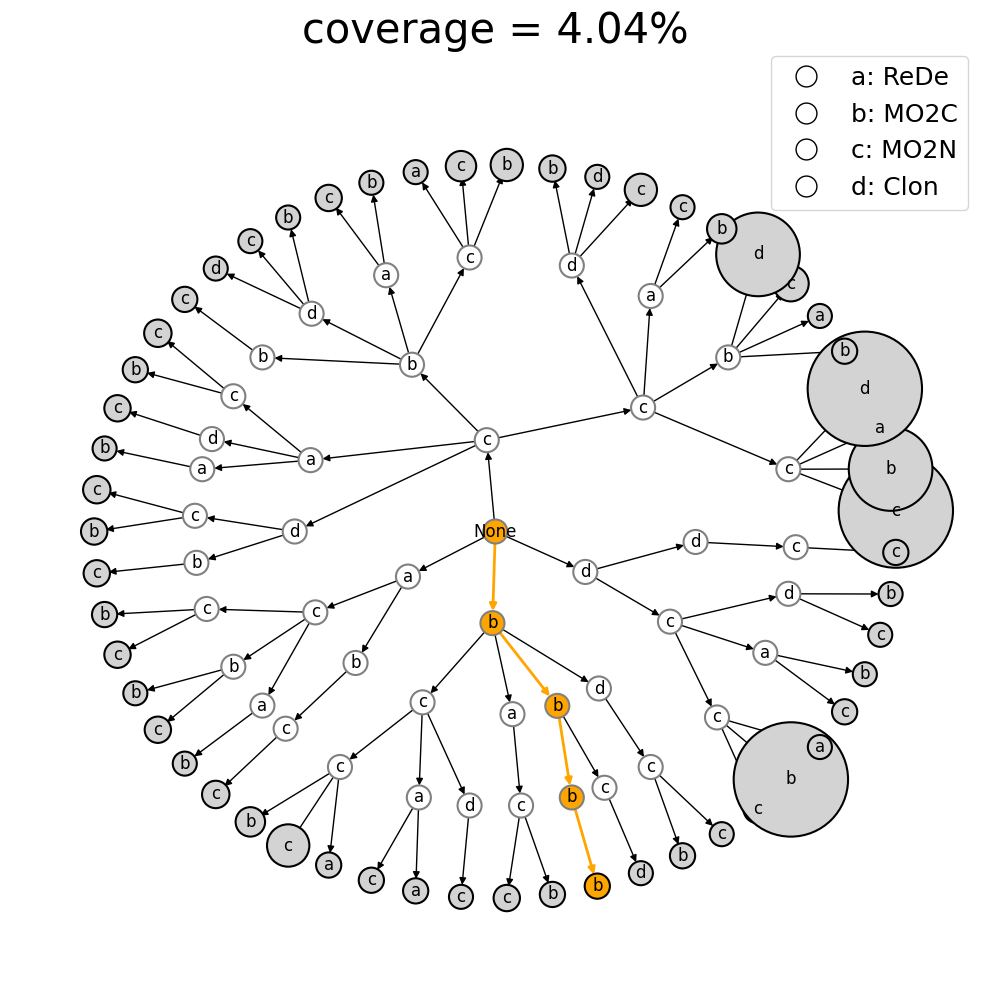

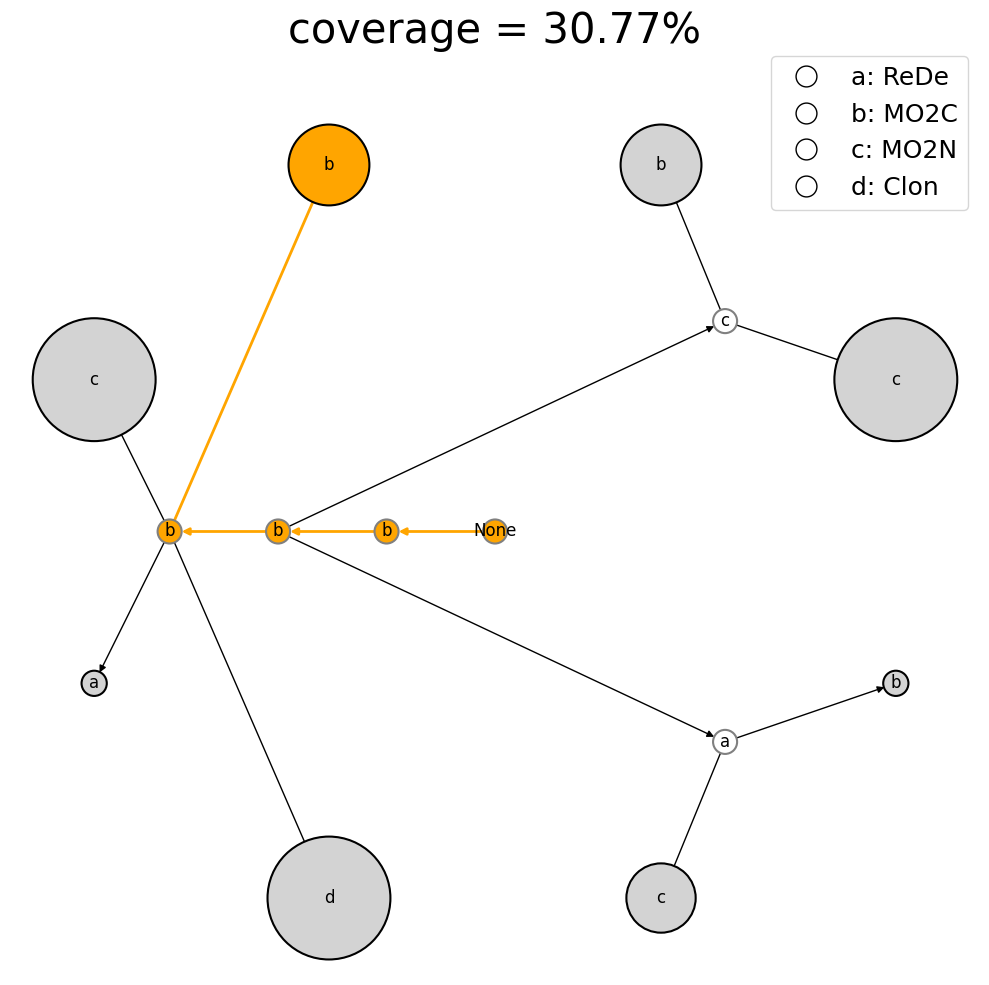

{'None': 'None',
 'c': 'Move_Operation_New_Component_New_Node',
 'b': 'Move_Operation_Component',
 'a': 'Move_Component_New_Node',
 'd': 'UMLCloneNode'}

In [69]:
# Code that loads 2 trees (in DOT format) and then compares them - TRAINTICKET
ref100_trie = parse_trie('./datasets/trainticket-nsgaii-it0_100_baseline_trie.dot')
it1_c258 = parse_trie('./datasets/trainticket-nsgaii-it1_50_c258_trie.dot')

compare_tries(ref100_trie, it1_c258, title1='Train-ticket / NSGAII / 100-baseline', title2='Train-ticket / NSGAII / c258')

110 nodes
109 edges
60 sequences
55 sequences
Encoding: {'None': 'None', 'c': 'Move_Operation_New_Component_New_Node', 'b': 'Move_Operation_Component', 'a': 'Move_Component_New_Node', 'd': 'UMLCloneNode'}
73
intersection: 37 ['cccc', 'cccb', 'cccd', 'ccbb', 'ccbc', 'ccbd', 'ccba', 'ccac', 'ccdc', 'ccdb', 'cbac', 'cbab', 'cbcc', 'cbcb', 'cbca', 'cbbc', 'cacb', 'cacc', 'cdcc', 'cdbc', 'bcac', 'bcaa', 'bccb', 'bccc', 'bcca', 'bcdc', 'bdcc', 'bacc', 'bacb', 'dccc', 'dccb', 'dcab', 'accb', 'accc', 'acbc', 'acbb', 'abcc']
Coverage of Train-ticket / NSGAII / 100-baseline on reference Train-ticket / NSGAII / 1000-baseline:  0.6513761467889908
Coverage of Train-ticket / NSGAII / 1000-baseline on reference Train-ticket / NSGAII / 100-baseline:  0.7171717171717171


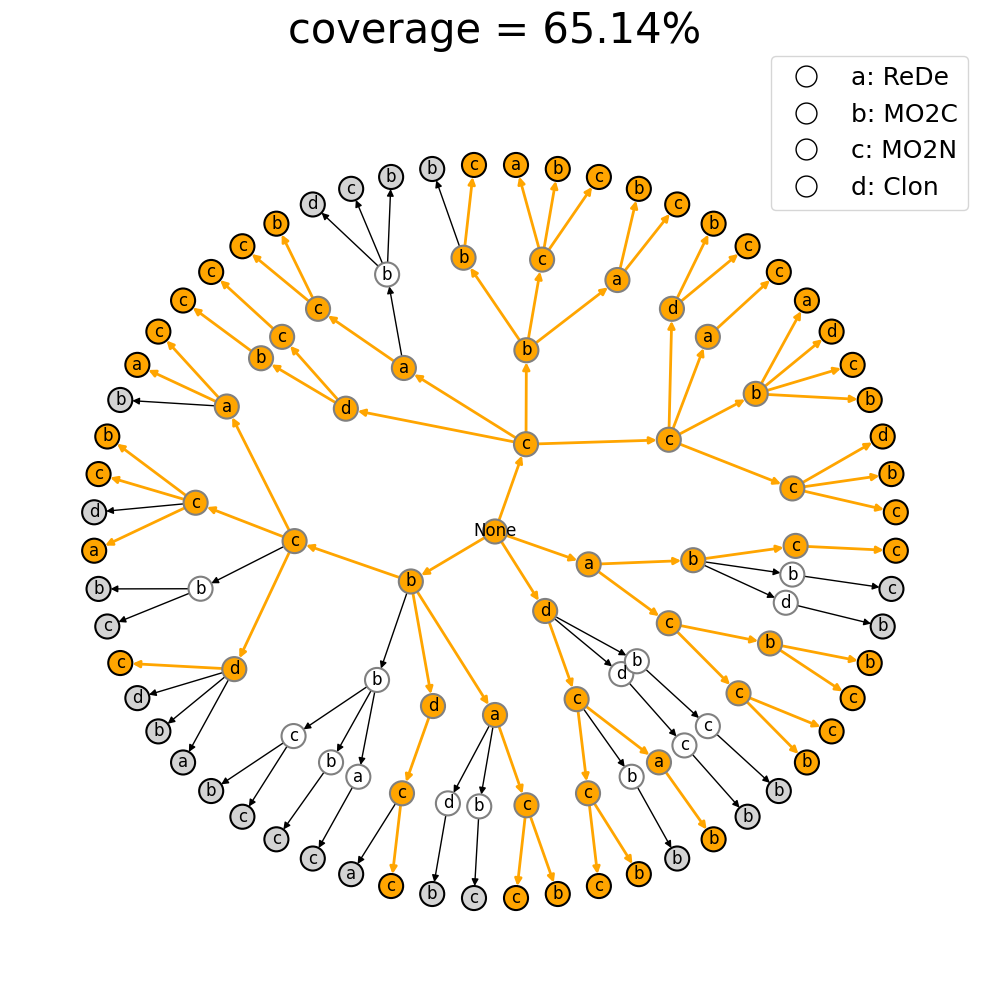

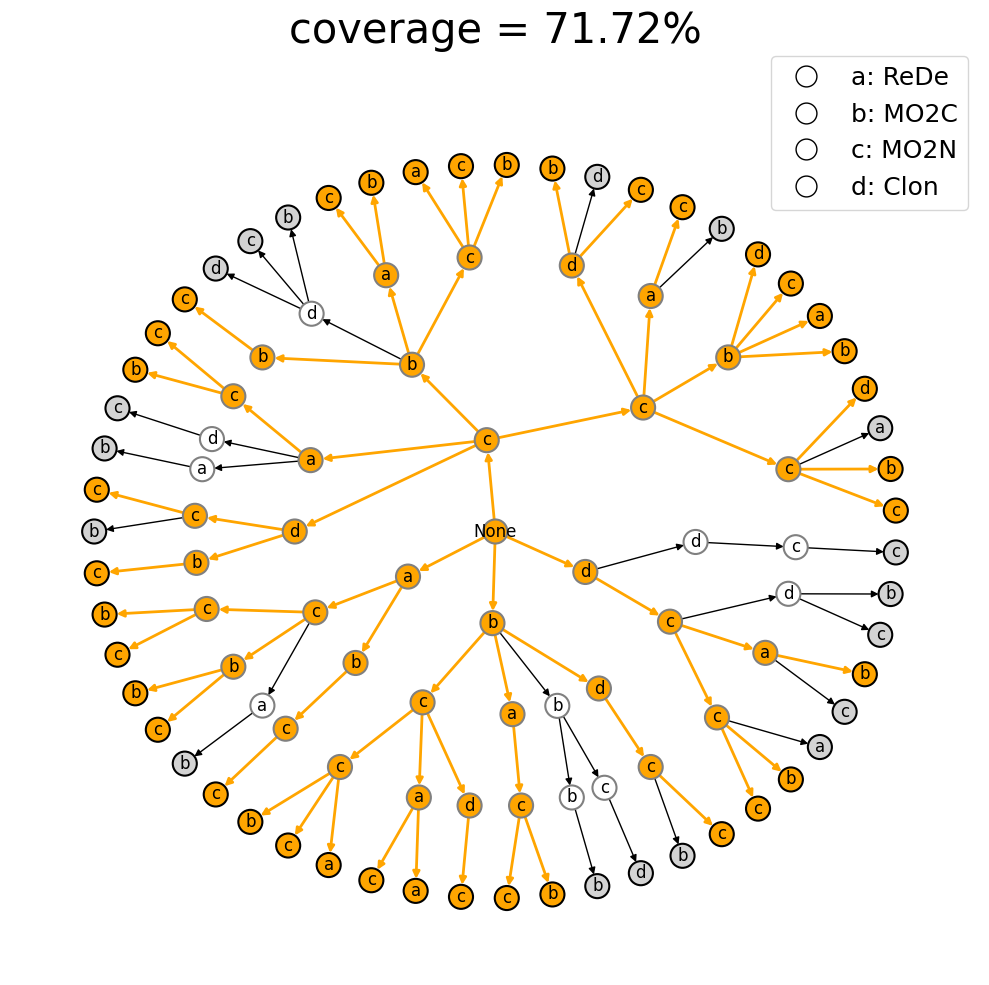

{'None': 'None',
 'c': 'Move_Operation_New_Component_New_Node',
 'b': 'Move_Operation_Component',
 'a': 'Move_Component_New_Node',
 'd': 'UMLCloneNode'}

In [70]:
ref1000_trie = parse_trie('./datasets/trainticket-nsgaii-it0_1000_baseline_trie.dot')

compare_tries(ref1000_trie, ref100_trie, title1='Train-ticket / NSGAII / 1000-baseline', title2='Train-ticket / NSGAII / 100-baseline', ninstances=False)

100 nodes
99 edges
17 nodes
16 edges
55 sequences
10 sequences
Encoding: {'None': 'None', 'c': 'Move_Operation_New_Component_New_Node', 'b': 'Move_Operation_Component', 'a': 'Move_Component_New_Node', 'd': 'UMLCloneNode'}
18
intersection: 10 ['cccc', 'cccb', 'ccca', 'ccbb', 'ccba', 'ccbc', 'ccbd', 'ccab', 'ccac', 'ccdb']
Coverage of Train-ticket / NSGAII / c223 on reference Train-ticket / NSGAII / 100-baseline:  0.16161616161616163
Coverage of Train-ticket / NSGAII / 100-baseline on reference Train-ticket / NSGAII / c223:  1.0


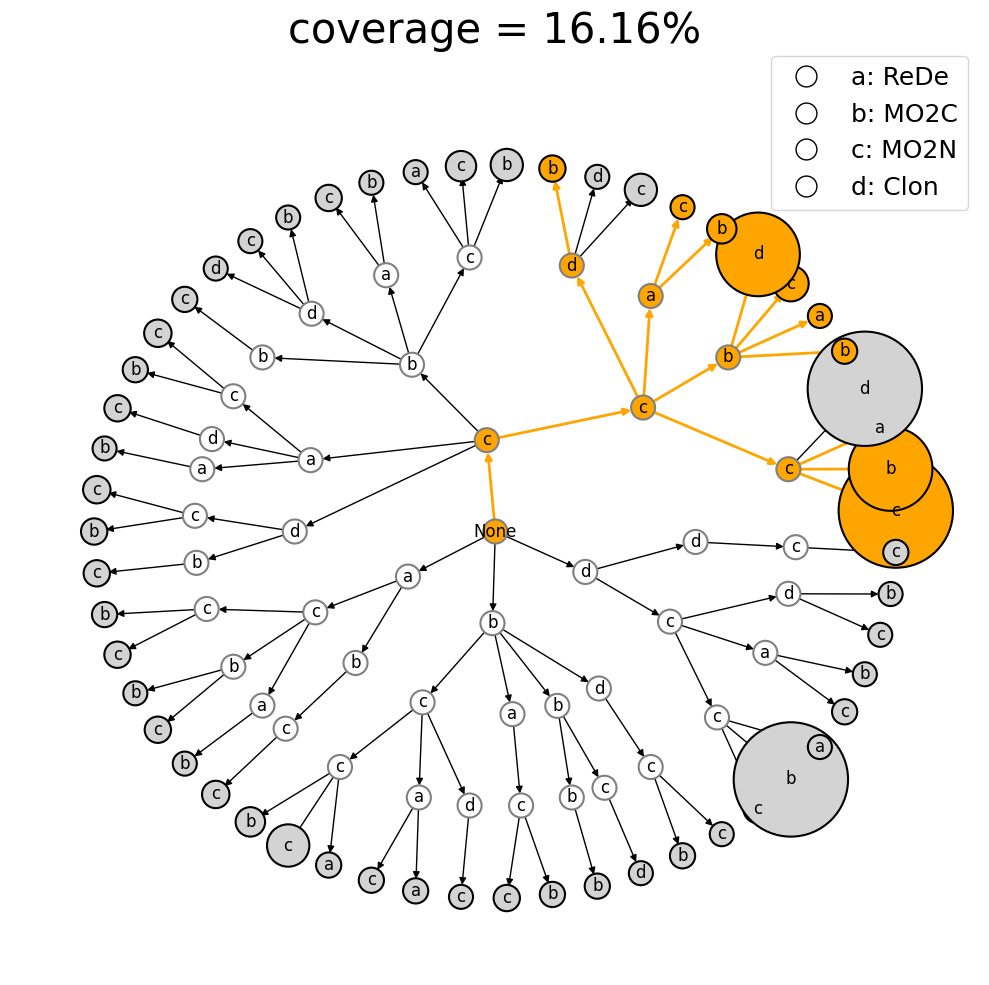

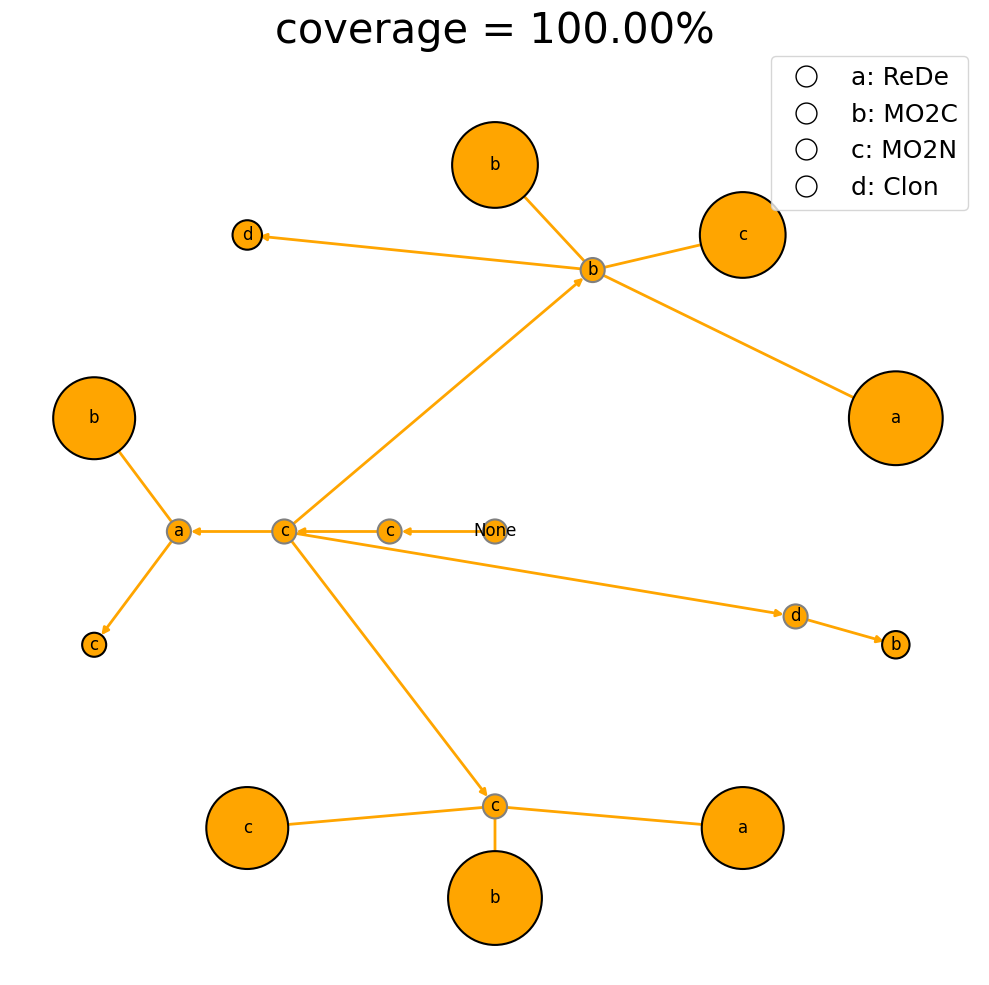

{'None': 'None',
 'c': 'Move_Operation_New_Component_New_Node',
 'b': 'Move_Operation_Component',
 'a': 'Move_Component_New_Node',
 'd': 'UMLCloneNode'}

In [71]:
# Code that loads 2 trees (in DOT format) and then compares them - TRAINTICKET
ref100_trie = parse_trie('./datasets/trainticket-nsgaii-it0_100_baseline_trie.dot')
it1_c223 = parse_trie('./datasets/trainticket-nsgaii-it1_50_c223_trie.dot')

compare_tries(ref100_trie, it1_c223, title1='Train-ticket / NSGAII / 100-baseline', title2='Train-ticket / NSGAII / c223')

60 sequences
10 sequences
Encoding: {'None': 'None', 'c': 'Move_Operation_New_Component_New_Node', 'b': 'Move_Operation_Component', 'a': 'Move_Component_New_Node', 'd': 'UMLCloneNode'}
16
intersection: 8 ['cccc', 'cccb', 'ccbb', 'ccbc', 'ccbd', 'ccba', 'ccac', 'ccdb']
Coverage of Train-ticket / NSGAII / c223 on reference Train-ticket / NSGAII / 1000-baseline:  0.12844036697247707
Coverage of Train-ticket / NSGAII / 1000-baseline on reference Train-ticket / NSGAII / c223:  0.875


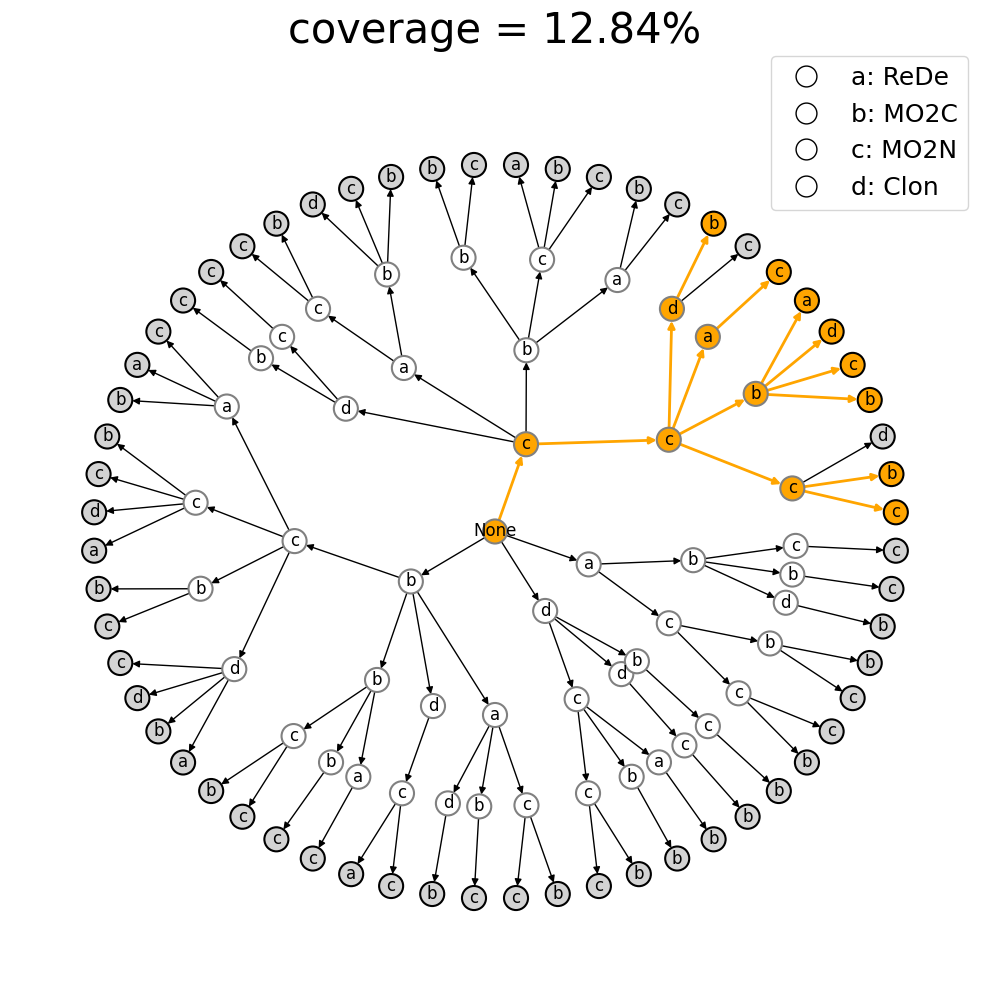

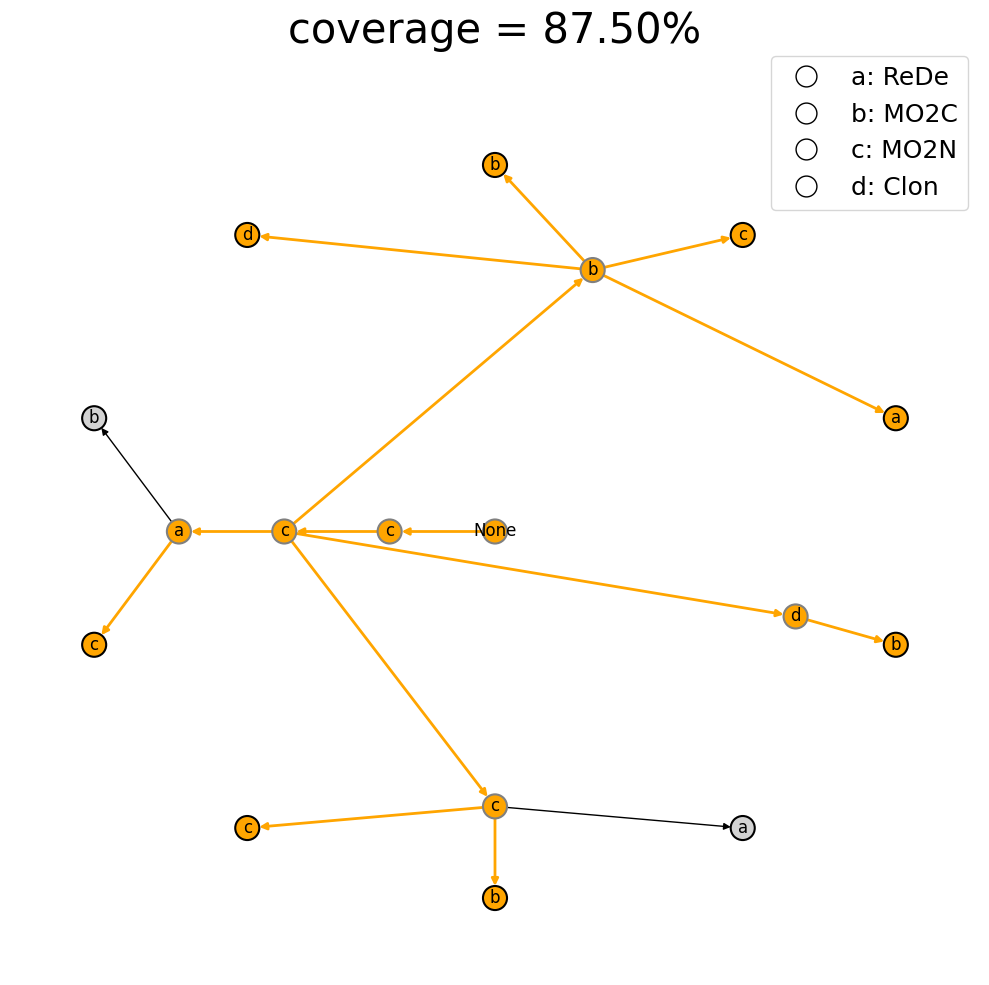

{'None': 'None',
 'c': 'Move_Operation_New_Component_New_Node',
 'b': 'Move_Operation_Component',
 'a': 'Move_Component_New_Node',
 'd': 'UMLCloneNode'}

In [72]:
compare_tries(ref1000_trie, it1_c223, title1='Train-ticket / NSGAII / 1000-baseline', title2='Train-ticket / NSGAII / c223', ninstances=False)

60 sequences
8 sequences
Encoding: {'None': 'None', 'c': 'Move_Operation_New_Component_New_Node', 'b': 'Move_Operation_Component', 'a': 'Move_Component_New_Node', 'd': 'UMLCloneNode'}
11
intersection: 4 ['bbcb', 'bbcc', 'bbbc', 'bbac']
Coverage of Train-ticket / NSGAII / c258 on reference Train-ticket / NSGAII / 1000-baseline:  0.08256880733944955
Coverage of Train-ticket / NSGAII / 1000-baseline on reference Train-ticket / NSGAII / c258:  0.6923076923076923


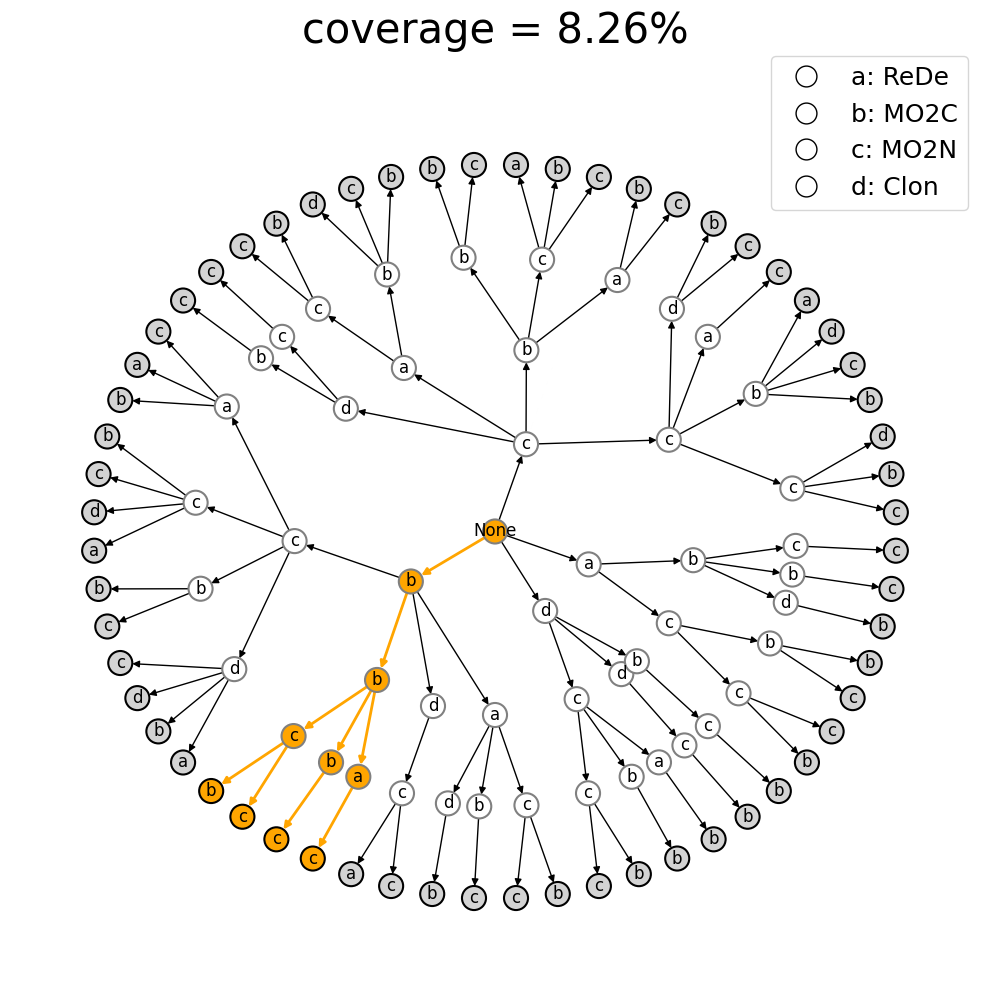

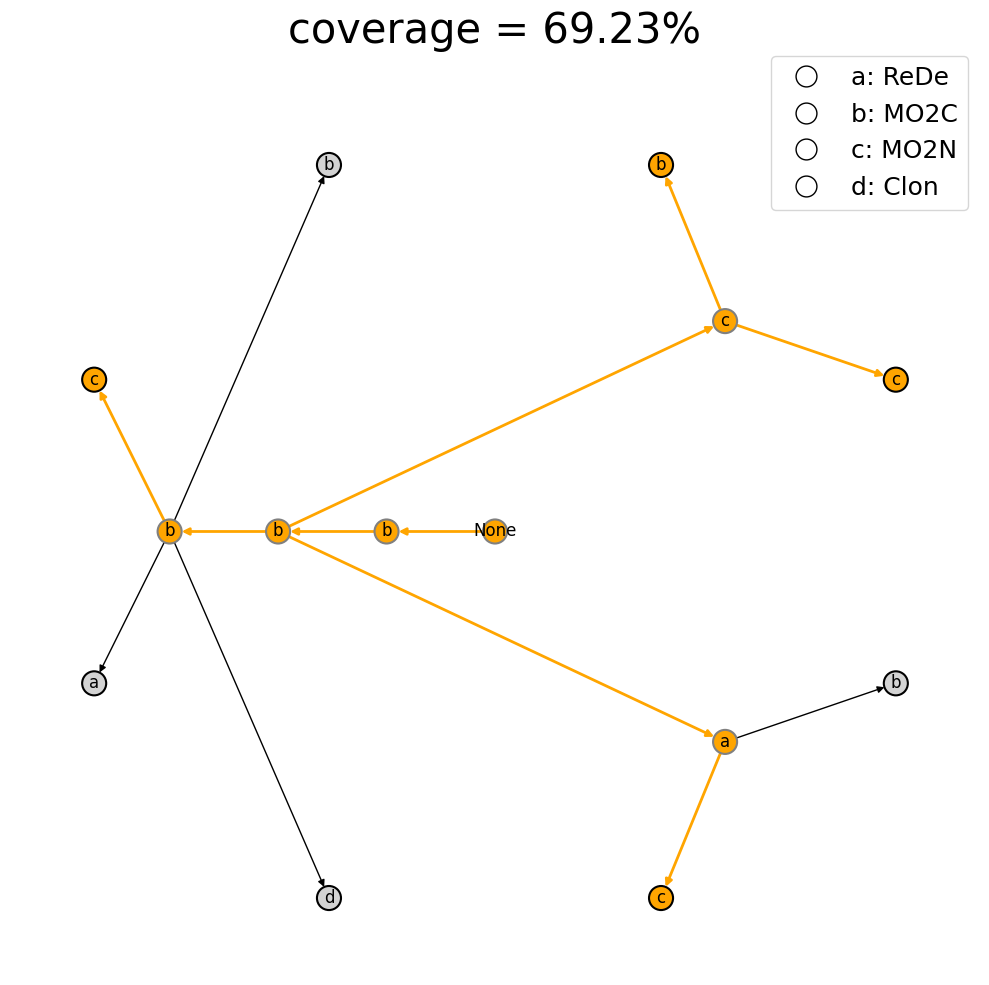

{'None': 'None',
 'c': 'Move_Operation_New_Component_New_Node',
 'b': 'Move_Operation_Component',
 'a': 'Move_Component_New_Node',
 'd': 'UMLCloneNode'}

In [73]:
compare_tries(ref1000_trie, it1_c258, title1='Train-ticket / NSGAII / 1000-baseline', title2='Train-ticket / NSGAII / c258', ninstances=False)

8 sequences
10 sequences
Encoding: {'None': 'None', 'b': 'Move_Operation_Component', 'c': 'Move_Operation_New_Component_New_Node', 'a': 'Move_Component_New_Node', 'd': 'UMLCloneNode'}
2
intersection: 0 []
Coverage of Train-ticket / NSGAII / c233 on reference Train-ticket / NSGAII / c258:  0.0
Coverage of Train-ticket / NSGAII / c258 on reference Train-ticket / NSGAII / c233:  0.0


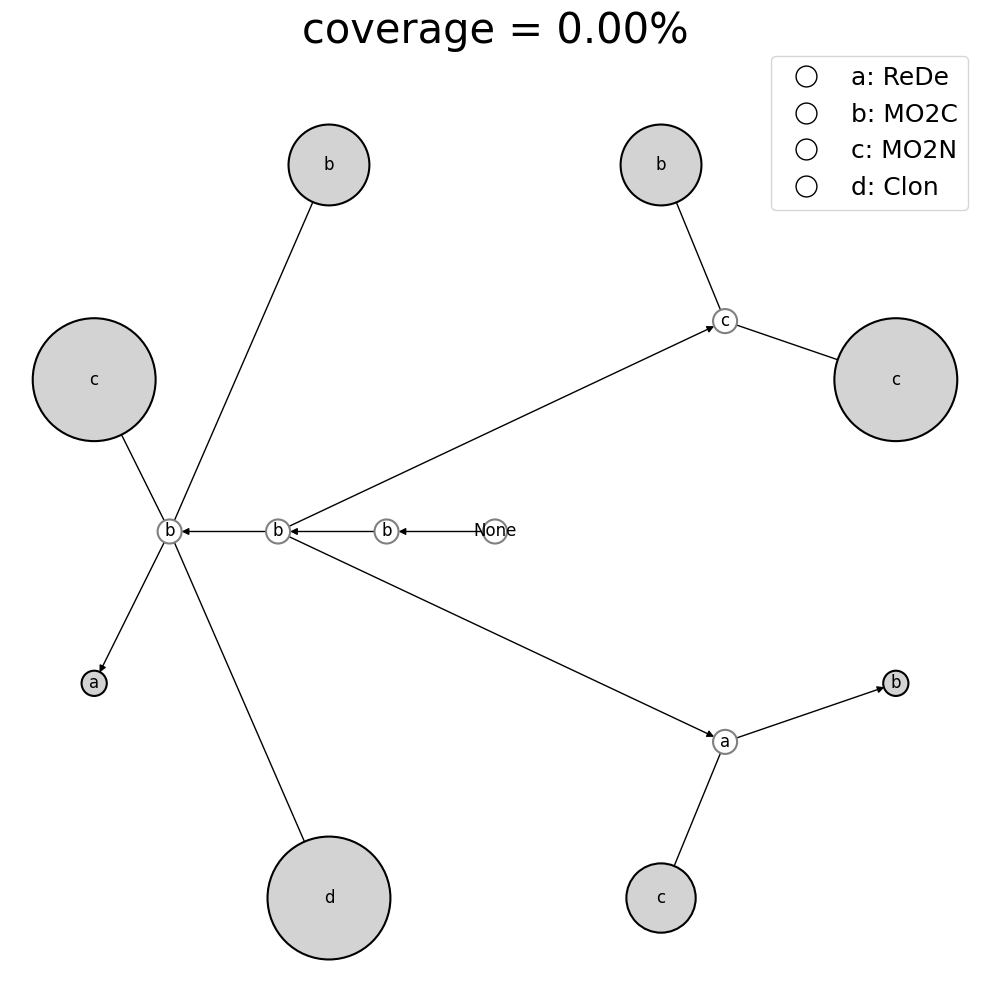

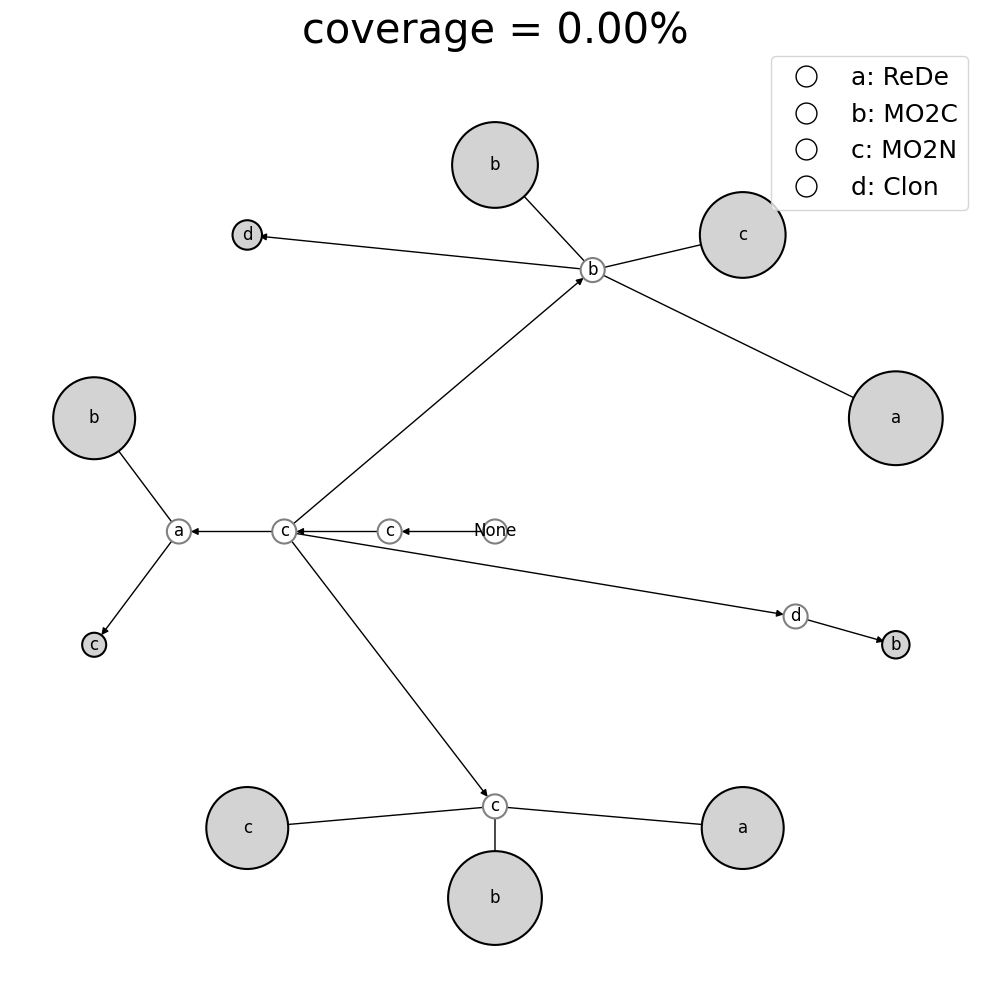

{'None': 'None',
 'b': 'Move_Operation_Component',
 'c': 'Move_Operation_New_Component_New_Node',
 'a': 'Move_Component_New_Node',
 'd': 'UMLCloneNode'}

In [74]:
compare_tries(it1_c258, it1_c223, title1='Train-ticket / NSGAII / c258', title2='Train-ticket / NSGAII / c233', size=(10,10))

---

In [75]:
import matplotlib # Common color map for everything
CMAP = matplotlib.colormaps['cubehelix']
COLORS = [CMAP(i) for i in np.linspace(0, 1, 3)]

## **Scatter Plots for Objective Spaces (and Pareto fronts)**

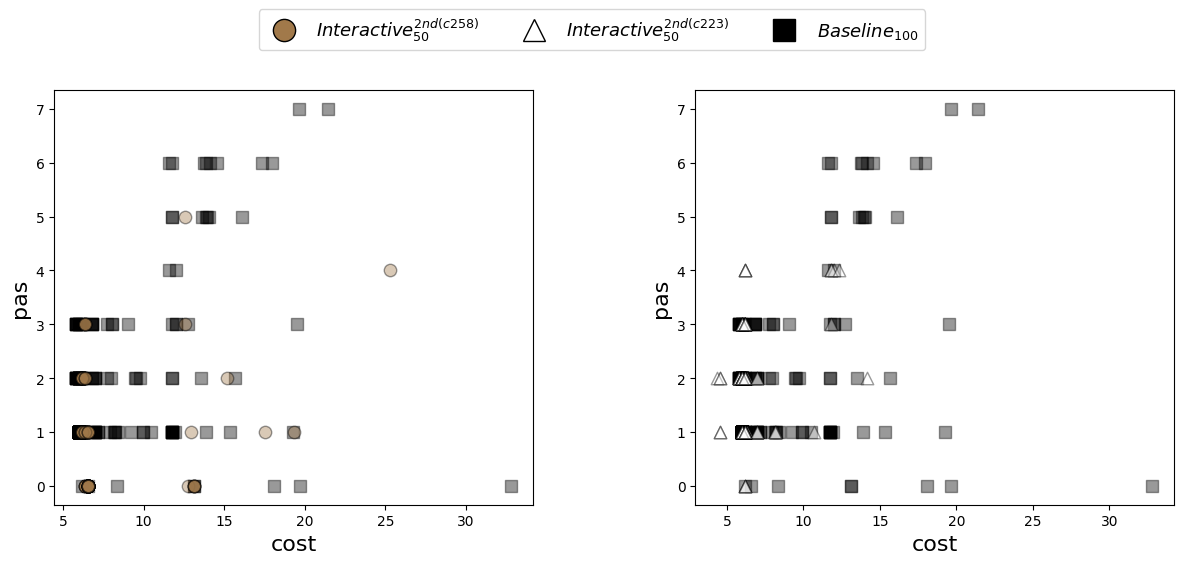

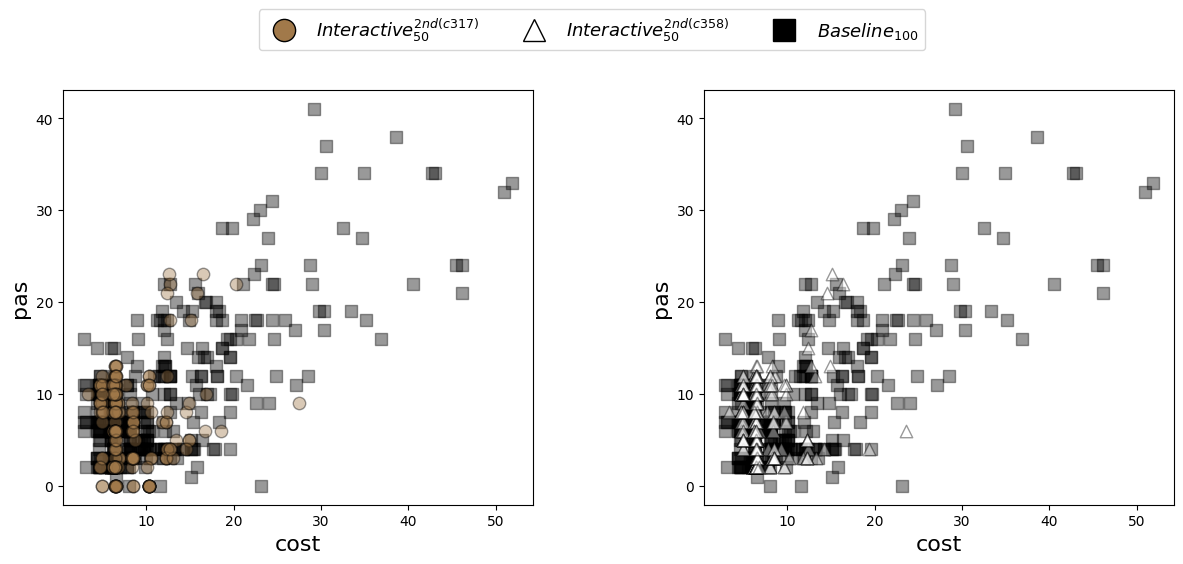

In [76]:
def create_scatter_plot(casestudy, centroids, xlimits=None, ylimits=None, figsize=(10, 5),
                        objectives=['#changes', 'pas'], colors=COLORS[1:3], markers=['o','^']):
  system = dict()
  system[centroids[0]] = pd.read_csv('./datasets/'+casestudy+'-nsgaii-it1_50_'+centroids[0]+'.csv')
  system[centroids[1]] = pd.read_csv('./datasets/'+casestudy+'-nsgaii-it1_50_'+centroids[1]+'.csv')
  baseline = pd.read_csv('./datasets/'+casestudy+'-nsgaii-it1_100.csv').sort_values(objectives, ascending=[True, False])
  baseline = baseline[objectives].values

  fig = plt.figure(figsize=figsize)
  axes = fig.subplots(1,2)

  i = 0
  for k, c, m in zip(system.keys(),colors, markers):
    pf = system[k][objectives].values
    axes[i].scatter(baseline[:, 0], baseline[:, 1], s=80, label='baseline', alpha=0.4, color=[COLORS[0]], linewidth=1, marker='s')
    axes[i].scatter(pf[:, 0], pf[:, 1], s=80, label=k, alpha=0.4, color=c, edgecolors='black', linewidth=1, marker=m)
    #axes[i].set_xlabel(objectives[0], fontsize=13)
    #axes[i].set_ylabel(objectives[1], fontsize=13)
    axes[i].set_xlabel('cost', fontsize=16)
    axes[i].set_ylabel('pas', fontsize=16)
    if xlimits is not None:
      axes[i].set_xlim(xlimits)
    if ylimits is not None:
      axes[i].set_ylim(ylimits)
    #axes[i].set_title('Train-ticket') #, rotation='vertical', x=-0.2,y=0.35, fontsize=16, color='white')
    i =+ 1

  labels = list(system.keys())
  label1 = '$Interactive_{50}^{2nd('+labels[0]+')}$'
  label2 = '$Interactive_{50}^{2nd('+labels[1]+')}$'
  legend_elements = [ Line2D([0], [0], marker=markers[0], color='w', label=label1, markeredgecolor='black', markerfacecolor=colors[0], markersize=16), 
                     Line2D([0], [0], marker=markers[1], color='w', label=label2, markeredgecolor='black', markerfacecolor=colors[1], markersize=16),
                     Line2D([0], [0], marker='s', color='w', label='$Baseline_{100}$', markeredgecolor='black', markerfacecolor=COLORS[0], markersize=16) ]
  fig.legend(handles=legend_elements, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=13)

  #fig.suptitle(casestudy, fontsize=15, fontweight='bold')
  fig.tight_layout(pad=8.5)
  plt.show()


# Train-ticket
centroids = ['c258', 'c223']
#x_limits = (2,41)
#y_limits = (-1,15)
create_scatter_plot('trainticket', centroids, figsize=(14,7)) #, x_limits, y_limits)

# Cocome
centroids = ['c317', 'c358']
#x_limits = (2,41)
#y_limits = (-1,15)
create_scatter_plot('cocome', centroids, figsize=(14,7)) #, x_limits, y_limits)

---